In [1]:
import pickle
import os
import sys
from statistics import mean
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
working_dir = os.getcwd()
os.chdir("../../..")
sys.path.append(os.getcwd())
from Internal_Representation.state import State
from Solver.action_tracker import ActionTracker
from runner import Runner
os.chdir(working_dir)

In [2]:
# Load pickled Object
def load_pickled_ob(file_name):
    with (open(file_name, "rb")) as openfile:
        while True:
            try:
                return pickle.load(openfile)
            except EOFError:
                break

In [3]:
# Display pickled actions_taken
def display_actions_taken(actions):
    for a in actions:
        print(a)

In [4]:
# Display pickled final state
def display_final_state(final_state):
    print(final_state)

In [188]:
size_dict = load_pickled_ob("problem_sizes.pickle")
save_graph_images = True
size_dict

{'basic/problem.jshop': 43,
 'rover/pb1.jshop': 441,
 'rover/pb2.jshop': 443,
 'rover/pb3.jshop': 463,
 'rover/pb4.jshop': 512,
 'rover/pb5.jshop': 597,
 'Barman/pfile01.hddl': 514,
 'Rover/pfile01.hddl': 415,
 'Rover/pfile02.hddl': 412,
 'Rover/pfile03.hddl': 427,
 'Rover/pfile04.hddl': 430,
 'Basic/pb1.hddl': 46,
 'Depots/p01.hddl': 302,
 'Depots/p02.hddl': 330,
 'Depots/p03.hddl': 358,
 'Depots/p04.hddl': 364,
 'Depots/p05.hddl': 414,
 'Depots/p06.hddl': 440,
 'Depots/p07.hddl': 356,
 'Depots/p08.hddl': 390,
 'Depots/p09.hddl': 471,
 'Depots/p10.hddl': 357,
 'Depots/p11.hddl': 435,
 'Depots/p12.hddl': 461,
 'Depots/p13.hddl': 391,
 'Depots/p14.hddl': 414,
 'Depots/p15.hddl': 517,
 'Factories/pfile01.hddl': 219,
 'Rover/p10.hddl': 1492,
 'Rover/p11.hddl': 1573,
 'Rover/p12.hddl': 1629,
 'Rover/p13.hddl': 1688,
 'Rover/p14.hddl': 1918,
 'Rover/p15.hddl': 1928,
 'Rover/p01.hddl': 483,
 'Rover/p02.hddl': 486,
 'Rover/p03.hddl': 501,
 'Rover/p04.hddl': 554,
 'Rover/p05.hddl': 633,
 'Rove

In [6]:
class average_time:
    def __init__(self):
        self.times = {} # {'roverp0': float}
        self.num_models = {}    # {'roverp0': float}

    def calculate_average_time(self, problem_name: str, times: list) -> None:
        self.times[problem_name] = mean(times)

    def calculate_average_model(self, problem_name: str, num_models: list) -> None:
        self.num_models[problem_name] = mean(num_models)

    def get_num_models(self, problem_name: str) -> float:
        return self.num_models[problem_name]

    def __getitem__(self, item):
        return self.times[item]

In [7]:
def generate_graph(example_names: list, config_names: list, colours: list, values: list,
                   title="Average Time Taken for Solving", y_axis="Average Time (Seconds)", **kwargs):
    assert len(config_names) == len(colours) == len(values)
    assert all([len(x) == len(example_names) for x in values]) or ("length_check" in kwargs and kwargs['length_check'] == False)

    if not 'fig_size' in kwargs:
        fig_size = (18, 8)
    else:
        fig_size = kwargs['fig_size']

    plt.figure(figsize=fig_size)
    # plt.gct().subplots_adjust(bottom=0.15)
    ax = plt.subplot()

    x_values = [size_dict[x] for x in example_names]

    i, l = 0, len(config_names)
    while i < l:
        y_values = [values[i][y] for y in range(len(values[i]))]

        if len(y_values) != len(x_values):
            assert "length_check" in kwargs and kwargs['length_check'] == False
            plot_x_values = x_values[:len(y_values)]
        else:
            plot_x_values = x_values

        ax.plot(plot_x_values, y_values, 'bo-', label=r'{}'.format(config_names[i]), color=colours[i], alpha=0.6, linewidth=3)
        i += 1

    if 'xscale' in kwargs:
        plt.xscale(kwargs['xscale'])
        plt.minorticks_off()

    if 'xticks' in kwargs:
        xticks = kwargs['xticks']
    else:
        xticks = x_values

    plt.xticks(xticks, [str(x) for x in xticks], rotation=45)
    ax.locator_params(axis='x', nbins=len(example_names))

    plt.xlabel('Problem Size'); plt.ylabel(r'{}'.format(y_axis))
    plt.title(r'{}'.format(title))
    plt.legend(loc='best')

    if save_graph_images and 'save_name' in kwargs:
        if not os.path.isdir('images'):
            os.mkdir('images')
        plt.savefig('images/' + kwargs['save_name'], dpi=500, bbox_inches="tight")  # Save graph to file
    plt.grid()

In [8]:
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
def significant_difference_check(list_approach_names: List[str], *args):
    """Check for statistically different data sets"""
    assert len(list_approach_names) == len(args)

    # Run shapiro test on all data
    data_values = [shapiro(x)[1] for x in args]
    data_normal = [x < 0.05 for x in data_values]

    # Assume we want to run dunn test
    run_dunn_test = True
    test_used = None

    # Run ANOVA or Kruskal test
    if all(x == False for x in data_normal):
        # Anova test
        print("All data is normally distributed")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denoted non-normal):", data_normal)

        if len(list_approach_names) >= 3:
            # One-way ANOVA
            # https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
            res = f_oneway(*args)[1]
            test_used = "One-Way ANOVA"
        else:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
            assert len(list_approach_names) == 2
            run_dunn_test = False
            res = ttest_ind(args[0], args[1])[1]
            test_used = "T-Test"
    else:
        # Kruskals test
        print("NOT FOLLOWING NORMAL DISTRIBUTION")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denotes non-normal):", data_normal)
        res = kruskal(*args)[1]
        test_used = "Kruskal-Wallis"

    if res <= 0.05:
        # There is significant difference
        print("Significant Difference found ({}). P-value: {}".format(test_used, res))
    else:
        # No significant difference
        print("NO Significant Difference found ({}). P-value: {}".format(test_used, res))
        run_dunn_test = False

    # Run Dunn Test
    if run_dunn_test:
        dunns_pairwise_test(list_approach_names, *args)

In [9]:
from scikit_posthocs import posthoc_dunn

def dunns_pairwise_test(list_approach_names: List[str], *args):

    d = []
    list_approach_names_extended = []
    i = 0
    while i < len(list_approach_names):
        for j in args[i]:
            d.append(j)
            list_approach_names_extended.append(list_approach_names[i])
        i += 1

    dataFrame = pd.DataFrame(list(zip(list_approach_names_extended, d)), columns=["Heuristic_Name", "Time_Taken"])
    # print(dataFrame)

    r = posthoc_dunn(dataFrame, "Time_Taken", "Heuristic_Name", p_adjust="hommel")
    print(r)

    # Print Results
    seen_pairs = []
    for i in r.keys():
        for j in r[i].keys():
            if j + i in seen_pairs:
                continue
            seen_pairs.append(i+j)

            if r[i][j] > 0.05 and i != j:
                print("No Significant Difference: {}, {} = {}".format(i, j, r[i][j]))
            elif i == j:
                pass
            else:
                print("Significant Difference: {}, {} = {}".format(i, j, r[i][j]))

# Running operations on collected Data

## Rover p0 -> p3 with early precondition checking and without

In [10]:
"""Load data from breadth first - no early precondition checker"""
breadth_first_no_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "rover_no_early_precon", "Breadth_First_Operations.csv")
breadth_first_no_early_precon_check = pd.read_csv(breadth_first_no_early_precon_check_data_path, sep=",")

breadth_first_no_early_precon_check_av_time = average_time()
for example_name in breadth_first_no_early_precon_check.example_name.unique():

    breadth_first_no_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_no_early_precon_check_av_time.calculate_average_model(example_name,                               breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_no_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.415648,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.413664,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.413168,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.415648,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.411184,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.047552,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.055984,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.052016,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.053008,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.064416,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [11]:
"""Load data from breadth first"""
breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations.csv")
breadth_first = pd.read_csv(breadth_first_data_path, sep=",")

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_av_time = average_time()
for example_name in breadth_first.example_name.unique():

    breadth_first_av_time.calculate_average_time(example_name, breadth_first[breadth_first['example_name'] == example_name]['time_taken'])

    breadth_first_av_time.calculate_average_model(example_name, breadth_first[breadth_first['example_name'] == example_name]['search_models_created'])

breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.406223,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.405728,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.452351,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.403743,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.406224,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.053503,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.045567,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.064911,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.071855,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.038622,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


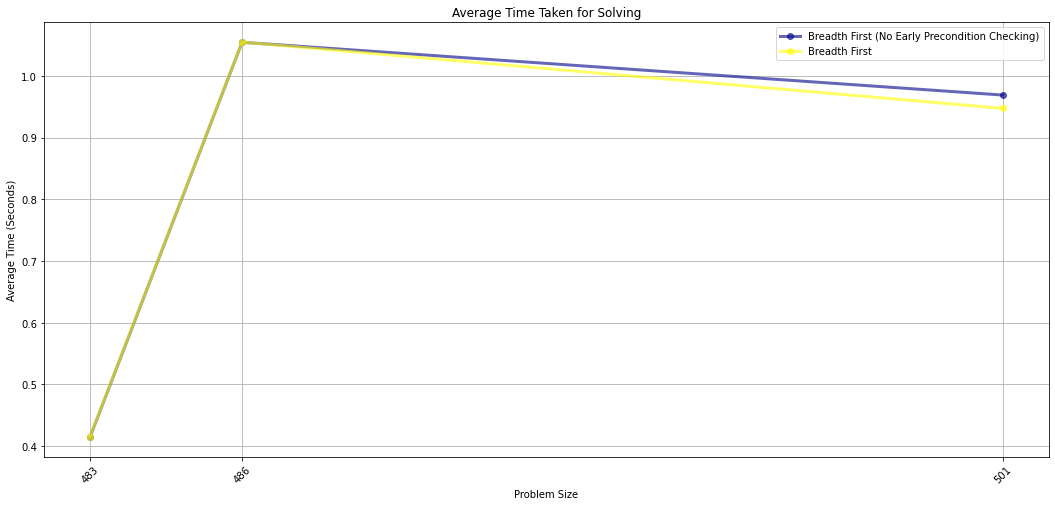

In [12]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Early Precondition Checking)", "Breadth First"], ["darkblue", "yellow"], [
[breadth_first_no_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p03.hddl"]],
[breadth_first_av_time["Rover/p01.hddl"],
 breadth_first_av_time["Rover/p02.hddl"],
 breadth_first_av_time["Rover/p03.hddl"]]
])

In [13]:
# Get test times for rover p01
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p01.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p01.hddl"]['time_taken']

print("Rover p01 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.4291726052761078, 0.0005682895425707102]
Non-Normal Check (False denotes non-normal): [False, True]
NO Significant Difference found (Kruskal-Wallis). P-value: 0.11718508719813842


In [14]:
# Get test times for rover p03
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p02.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p02.hddl"]['time_taken']

print("Rover p02 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p02 Statistically Significant Test
All data is normally distributed
Shapiro p-values: [0.678989589214325, 0.8437691330909729]
Non-Normal Check (False denoted non-normal): [False, False]
NO Significant Difference found (T-Test). P-value: 0.965867574497757


In [15]:
# Get test times for rover p03
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p03.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p03.hddl"]['time_taken']

print("Rover p03 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p03 Statistically Significant Test
All data is normally distributed
Shapiro p-values: [0.30605143308639526, 0.9451758861541748]
Non-Normal Check (False denoted non-normal): [False, False]
Significant Difference found (T-Test). P-value: 0.0004181718922834229


## Import Remainder of data
### Breadth First
### Breadth First Pruning
### Hamming Distance
### Tree Distance
### Delete Relaxed

In [16]:
breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.406223,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.405728,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.452351,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.403743,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.406224,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.053503,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.045567,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.064911,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.071855,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.038622,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [17]:
"""Load data from breadth first pruning"""
breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.read_csv(breadth_first_pruning_data_path, sep=",")

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_av_time = average_time()
for example_name in breadth_first_pruning.example_name.unique():
    breadth_first_pruning_av_time.calculate_average_time(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['time_taken'])

    breadth_first_pruning_av_time.calculate_average_model(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['search_models_created'])

breadth_first_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.066960,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.084320,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.065472,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.067456,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.064971,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.101184,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.094239,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,0.093743,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.105648,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.094736,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [18]:
"""Load data for Hamming Distance"""
hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Hamming_Distance.csv")
hamming_distance = pd.read_csv(hamming_distance_data_path, sep=",")

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_av_time = average_time()
for example_name in hamming_distance.example_name.unique():
    hamming_distance_av_time.calculate_average_time(example_name, hamming_distance[hamming_distance['example_name'] == example_name]['time_taken'])

    hamming_distance_av_time.calculate_average_model(example_name, hamming_distance[hamming_distance['example_name'] == example_name]['search_models_created'])

hamming_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.100688,501,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
1,Rover/p01.hddl,0.099199,501,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
2,Rover/p01.hddl,0.098704,501,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
3,Rover/p01.hddl,0.097215,501,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
4,Rover/p01.hddl,0.097216,501,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
5,Rover/p02.hddl,0.152768,797,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
6,Rover/p02.hddl,0.160703,797,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
7,Rover/p02.hddl,0.154752,797,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
8,Rover/p02.hddl,0.153760,797,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
9,Rover/p02.hddl,0.161696,797,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...


In [19]:
"""Load data for Hamming Distance"""
hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "hamming_distance_GBFS.csv")
hamming_distance_GBFS = pd.read_csv(hamming_distance_GBFS_data_path, sep=",")

hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "hamming_distance_GBFS.csv")
hamming_distance_GBFS = pd.concat([hamming_distance_GBFS, pd.read_csv(hamming_distance_GBFS_data_path, sep=",")])

hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "hamming_distance_GBFS.csv")
hamming_distance_GBFS = pd.concat([hamming_distance_GBFS, pd.read_csv(hamming_distance_GBFS_data_path, sep=",")])

hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "hamming_distance_GBFS.csv")
hamming_distance_GBFS = pd.concat([hamming_distance_GBFS, pd.read_csv(hamming_distance_GBFS_data_path, sep=",")])

hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "translog", "hamming_distance_GBFS.csv")
hamming_distance_GBFS = pd.concat([hamming_distance_GBFS, pd.read_csv(hamming_distance_GBFS_data_path, sep=",")])

hamming_distance_GBFS_av_time = average_time()
for example_name in hamming_distance_GBFS.example_name.unique():
    hamming_distance_GBFS_av_time.calculate_average_time(example_name, hamming_distance_GBFS[hamming_distance_GBFS['example_name'] == example_name]['time_taken'])

    hamming_distance_GBFS_av_time.calculate_average_model(example_name, hamming_distance_GBFS[hamming_distance_GBFS['example_name'] == example_name]['search_models_created'])

hamming_distance_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.032736,195,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
1,Rover/p01.hddl,0.036207,195,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
2,Rover/p01.hddl,0.034224,195,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
3,Rover/p01.hddl,0.037200,195,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
4,Rover/p01.hddl,0.041664,195,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
5,Rover/p02.hddl,0.102175,363,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
6,Rover/p02.hddl,0.086798,363,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
7,Rover/p02.hddl,0.069934,363,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
8,Rover/p02.hddl,0.065968,363,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
9,Rover/p02.hddl,0.064975,363,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...


In [20]:
"""Load data for Hamming Distance"""
hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "hamming_distance_GCost.csv")
hamming_distance_GCost = pd.read_csv(hamming_distance_GCost_data_path, sep=",")

hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "hamming_distance_GCost.csv")
hamming_distance_GCost = pd.concat([hamming_distance_GCost, pd.read_csv(hamming_distance_GCost_data_path, sep=",")])

hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "hamming_distance_GCost.csv")
hamming_distance_GCost = pd.concat([hamming_distance_GCost, pd.read_csv(hamming_distance_GCost_data_path, sep=",")])

hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "hamming_distance_GCost.csv")
hamming_distance_GCost = pd.concat([hamming_distance_GCost, pd.read_csv(hamming_distance_GCost_data_path, sep=",")])

hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "translog", "hamming_distance_GCost.csv")
hamming_distance_GCost = pd.concat([hamming_distance_GCost, pd.read_csv(hamming_distance_GCost_data_path, sep=",")])

hamming_distance_GCost_av_time = average_time()
for example_name in hamming_distance_GCost.example_name.unique():
    hamming_distance_GCost_av_time.calculate_average_time(example_name, hamming_distance_GCost[hamming_distance_GCost['example_name'] == example_name]['time_taken'])

    hamming_distance_GCost_av_time.calculate_average_model(example_name, hamming_distance_GCost[hamming_distance_GCost['example_name'] == example_name]['search_models_created'])

hamming_distance_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.084319,459,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
1,Rover/p01.hddl,0.080351,459,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
2,Rover/p01.hddl,0.080848,459,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
3,Rover/p01.hddl,0.089280,459,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
4,Rover/p01.hddl,0.081840,459,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
5,Rover/p02.hddl,0.141359,767,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
6,Rover/p02.hddl,0.141360,767,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
7,Rover/p02.hddl,0.139872,767,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
8,Rover/p02.hddl,0.141359,767,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
9,Rover/p02.hddl,0.142848,767,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...


In [21]:
"""Load data for Tree Distance"""
tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Tree_Distance.csv")
tree_distance = pd.read_csv(tree_distance_data_path, sep=",")

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_av_time = average_time()
for example_name in tree_distance.example_name.unique():
    tree_distance_av_time.calculate_average_time(example_name, tree_distance[tree_distance['example_name'] == example_name]['time_taken'])

    tree_distance_av_time.calculate_average_model(example_name, tree_distance[tree_distance['example_name'] == example_name]['search_models_created'])

tree_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.006448,63,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
1,Rover/p01.hddl,0.006448,63,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
2,Rover/p01.hddl,0.009424,63,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
3,Rover/p01.hddl,0.006448,63,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
4,Rover/p01.hddl,0.005952,63,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
...,...,...,...,...,...
0,um-translog01/problem.hddl,0.101183,1289,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
1,um-translog01/problem.hddl,0.095232,1289,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
2,um-translog01/problem.hddl,0.103664,1289,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
3,um-translog01/problem.hddl,0.100192,1289,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...


In [22]:
"""Load data for Tree Distance"""
tree_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "tree_distance_GBFS.csv")
tree_distance_GBFS = pd.read_csv(tree_distance_GBFS_data_path, sep=",")

tree_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "tree_distance_GBFS.csv")
tree_distance_GBFS = pd.concat([tree_distance_GBFS, pd.read_csv(tree_distance_GBFS_data_path, sep=",")])

tree_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "tree_distance_GBFS.csv")
tree_distance_GBFS = pd.concat([tree_distance_GBFS, pd.read_csv(tree_distance_GBFS_data_path, sep=",")])

tree_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "translog", "tree_distance_GBFS.csv")
tree_distance_GBFS = pd.concat([tree_distance_GBFS, pd.read_csv(tree_distance_GBFS_data_path, sep=",")])

tree_distance_GBFS_av_time = average_time()
for example_name in tree_distance_GBFS.example_name.unique():
    tree_distance_GBFS_av_time.calculate_average_time(example_name, tree_distance_GBFS[tree_distance_GBFS['example_name'] == example_name]['time_taken'])

    tree_distance_GBFS_av_time.calculate_average_model(example_name, tree_distance_GBFS[tree_distance_GBFS['example_name'] == example_name]['search_models_created'])

tree_distance_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.005456,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
1,Rover/p01.hddl,0.008926,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
2,Rover/p01.hddl,0.004960,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
3,Rover/p01.hddl,0.004464,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
4,Rover/p01.hddl,0.008928,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
...,...,...,...,...,...
0,um-translog01/problem.hddl,0.019344,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
1,um-translog01/problem.hddl,0.013392,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
2,um-translog01/problem.hddl,0.014384,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
3,um-translog01/problem.hddl,0.013392,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...


In [23]:
"""Load data for Tree Distance"""
tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "tree_distance_GCost.csv")
tree_distance_GCost = pd.read_csv(tree_distance_GCost_data_path, sep=",")

tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "tree_distance_GCost.csv")
tree_distance_GCost = pd.concat([tree_distance_GCost, pd.read_csv(tree_distance_GCost_data_path, sep=",")])

tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "tree_distance_GCost.csv")
tree_distance_GCost = pd.concat([tree_distance_GCost, pd.read_csv(tree_distance_GCost_data_path, sep=",")])

tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "tree_distance_GCost.csv")
tree_distance_GCost = pd.concat([tree_distance_GCost, pd.read_csv(tree_distance_GCost_data_path, sep=",")])

tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "translog", "tree_distance_GCost.csv")
tree_distance_GCost = pd.concat([tree_distance_GCost, pd.read_csv(tree_distance_GCost_data_path, sep=",")])

tree_distance_GCost_av_time = average_time()
for example_name in tree_distance_GCost.example_name.unique():
    tree_distance_GCost_av_time.calculate_average_time(example_name, tree_distance_GCost[tree_distance_GCost['example_name'] == example_name]['time_taken'])

    tree_distance_GCost_av_time.calculate_average_model(example_name, tree_distance_GCost[tree_distance_GCost['example_name'] == example_name]['search_models_created'])

tree_distance_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.005456,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
1,Rover/p01.hddl,0.005952,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
2,Rover/p01.hddl,0.004960,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
3,Rover/p01.hddl,0.007936,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
4,Rover/p01.hddl,0.007935,45,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
...,...,...,...,...,...
0,um-translog01/problem.hddl,0.013888,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
1,um-translog01/problem.hddl,0.013392,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
2,um-translog01/problem.hddl,0.013888,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...
3,um-translog01/problem.hddl,0.012896,218,serialised_objects\um-translog01_problemhddl_T...,serialised_objects\um-translog01_problemhddl_T...


In [24]:
"""Load data for Delete Relaxed"""
delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Delete_Relaxed.csv")
delete_relaxed = pd.read_csv(delete_relaxed_data_path, sep=",")

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_av_time = average_time()
for example_name in delete_relaxed.example_name.unique():
    delete_relaxed_av_time.calculate_average_time(example_name, delete_relaxed[delete_relaxed['example_name'] == example_name]['time_taken'])

    delete_relaxed_av_time.calculate_average_model(example_name, delete_relaxed[delete_relaxed['example_name'] == example_name]['search_models_created'])

delete_relaxed

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,9.120931,950,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
1,Rover/p01.hddl,7.659221,950,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
2,Rover/p01.hddl,7.826869,950,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
3,Rover/p01.hddl,7.679558,950,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
4,Rover/p01.hddl,7.667157,950,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
5,Rover/p02.hddl,11.523056,1564,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
6,Rover/p02.hddl,11.775520,1564,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
7,Rover/p02.hddl,11.589520,1564,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
8,Rover/p02.hddl,11.545871,1564,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
9,Rover/p02.hddl,12.031951,1564,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...


In [25]:
"""Load data for Delete Relaxed"""
delete_relaxed_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Delete_Relaxed_GBFS.csv")
delete_relaxed_GBFS = pd.read_csv(delete_relaxed_GBFS_data_path, sep=",")

delete_relaxed_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Delete_Relaxed_GBFS.csv")
delete_relaxed_GBFS = pd.concat([delete_relaxed_GBFS, pd.read_csv(delete_relaxed_GBFS_data_path, sep=",")])

delete_relaxed_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Delete_Relaxed_GBFS.csv")
delete_relaxed_GBFS = pd.concat([delete_relaxed_GBFS, pd.read_csv(delete_relaxed_GBFS_data_path, sep=",")])

delete_relaxed_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Delete_Relaxed_GBFS.csv")
delete_relaxed_GBFS = pd.concat([delete_relaxed_GBFS, pd.read_csv(delete_relaxed_GBFS_data_path, sep=",")])

delete_relaxed_GBFS_av_time = average_time()
for example_name in delete_relaxed_GBFS.example_name.unique():
    delete_relaxed_GBFS_av_time.calculate_average_time(example_name, delete_relaxed_GBFS[delete_relaxed_GBFS['example_name'] == example_name]['time_taken'])

    delete_relaxed_GBFS_av_time.calculate_average_model(example_name, delete_relaxed_GBFS[delete_relaxed_GBFS['example_name'] == example_name]['search_models_created'])

delete_relaxed_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,1.630846,224,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
1,Rover/p01.hddl,2.524140,224,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
2,Rover/p01.hddl,1.640270,224,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
3,Rover/p01.hddl,1.624398,224,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
4,Rover/p01.hddl,1.644733,224,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
5,Rover/p02.hddl,1.680941,244,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
6,Rover/p02.hddl,1.687389,244,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
7,Rover/p02.hddl,1.656636,244,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
8,Rover/p02.hddl,1.649693,244,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
9,Rover/p02.hddl,1.638285,244,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...


In [26]:
"""Load data for Delete Relaxed"""
delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "delete_relaxed_GCost.csv")
delete_relaxed_GCost = pd.read_csv(delete_relaxed_GCost_data_path, sep=",")

delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "delete_relaxed_GCost.csv")
delete_relaxed_GCost = pd.concat([delete_relaxed_GCost, pd.read_csv(delete_relaxed_GCost_data_path, sep=",")])

delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "translog", "delete_relaxed_GCost.csv")
delete_relaxed_GCost = pd.concat([delete_relaxed_GCost, pd.read_csv(delete_relaxed_GCost_data_path, sep=",")])

delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "delete_relaxed_GCost.csv")
delete_relaxed_GCost = pd.concat([delete_relaxed_GCost, pd.read_csv(delete_relaxed_GCost_data_path, sep=",")])

delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "delete_relaxed_GCost.csv")
delete_relaxed_GCost = pd.concat([delete_relaxed_GCost, pd.read_csv(delete_relaxed_GCost_data_path, sep=",")])

delete_relaxed_GCost_av_time = average_time()
for example_name in delete_relaxed_GCost.example_name.unique():
    delete_relaxed_GCost_av_time.calculate_average_time(example_name, delete_relaxed_GCost[delete_relaxed_GCost['example_name'] == example_name]['time_taken'])

    delete_relaxed_GCost_av_time.calculate_average_model(example_name, delete_relaxed_GCost[delete_relaxed_GCost['example_name'] == example_name]['search_models_created'])

delete_relaxed_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,3.871275,515,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
1,Rover/p01.hddl,4.252202,515,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
2,Rover/p01.hddl,4.315194,515,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
3,Rover/p01.hddl,3.905498,515,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
4,Rover/p01.hddl,3.894587,515,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
5,Rover/p02.hddl,6.895380,921,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
6,Rover/p02.hddl,6.713845,921,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
7,Rover/p02.hddl,6.902820,921,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
8,Rover/p02.hddl,6.670692,921,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...
9,Rover/p02.hddl,6.662757,921,serialised_objects\Rover_p02hddl_Delete_Relaxe...,serialised_objects\Rover_p02hddl_Delete_Relaxe...


## Graph for Rover - Breadth First

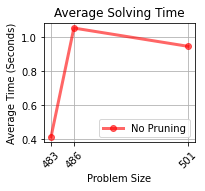

In [27]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["No Pruning"], ["red"],
               [
                   [breadth_first_av_time["Rover/p01.hddl"],
                    breadth_first_av_time["Rover/p02.hddl"],
                    breadth_first_av_time["Rover/p03.hddl"]]
               ], "Average Solving Time", save_name='TO_Rover_BF.pdf', fig_size=(2.7,2.2))

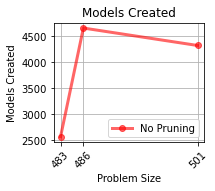

In [28]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["No Pruning"], ["red"],
               [
                   [breadth_first_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p03.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Rover_BF_Models.pdf', fig_size=(2.7,2.2))

## Graph for Rover - Breadth First (Pruning)

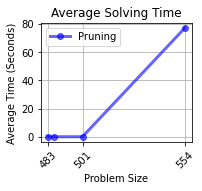

In [29]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl"], ["Pruning"], ["blue"],
               [
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Rover/p02.hddl"],
                    breadth_first_pruning_av_time["Rover/p03.hddl"],
                    breadth_first_pruning_av_time["Rover/p04.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Rover_BFP.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p03.hddl"], size_dict["Rover/p04.hddl"]])

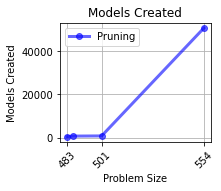

In [30]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl"], ["Pruning"], ["blue"],
               [
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p04.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Rover_BFP_Models.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p03.hddl"], size_dict["Rover/p04.hddl"]])

## Graphs for Rover - Delete Relaxed

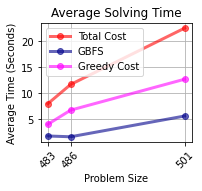

In [31]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [delete_relaxed_av_time["Rover/p01.hddl"],
                    delete_relaxed_av_time["Rover/p02.hddl"],
                    delete_relaxed_av_time["Rover/p03.hddl"]],
                   [delete_relaxed_GBFS_av_time["Rover/p01.hddl"],
                    delete_relaxed_GBFS_av_time["Rover/p02.hddl"],
                    delete_relaxed_GBFS_av_time["Rover/p03.hddl"]],
                   [delete_relaxed_GCost_av_time["Rover/p01.hddl"],
                    delete_relaxed_GCost_av_time["Rover/p02.hddl"],
                    delete_relaxed_GCost_av_time["Rover/p03.hddl"]]
               ], "Average Solving Time", save_name='TO_Rover_DR.pdf', fig_size=(2.7,2.2))

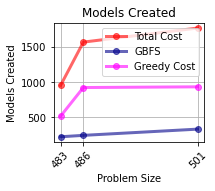

In [32]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [delete_relaxed_av_time.get_num_models("Rover/p01.hddl"),
                    delete_relaxed_av_time.get_num_models("Rover/p02.hddl"),
                    delete_relaxed_av_time.get_num_models("Rover/p03.hddl")
               ],
                   [delete_relaxed_GBFS_av_time.get_num_models("Rover/p01.hddl"),
                    delete_relaxed_GBFS_av_time.get_num_models("Rover/p02.hddl"),
                    delete_relaxed_GBFS_av_time.get_num_models("Rover/p03.hddl")
                    ],
                   [delete_relaxed_GCost_av_time.get_num_models("Rover/p01.hddl"),
                    delete_relaxed_GCost_av_time.get_num_models("Rover/p02.hddl"),
                    delete_relaxed_GCost_av_time.get_num_models("Rover/p03.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Rover_DR_Models.pdf', fig_size=(2.7,2.2))

## Graphs for Rover - Hamming Distance

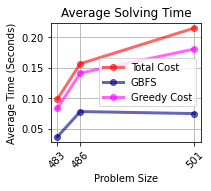

In [33]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Rover/p02.hddl"],
                    hamming_distance_av_time["Rover/p03.hddl"]
                    ],
                   [hamming_distance_GBFS_av_time["Rover/p01.hddl"],
                    hamming_distance_GBFS_av_time["Rover/p02.hddl"],
                    hamming_distance_GBFS_av_time["Rover/p03.hddl"]
                    ],
                   [hamming_distance_GCost_av_time["Rover/p01.hddl"],
                    hamming_distance_GCost_av_time["Rover/p02.hddl"],
                    hamming_distance_GCost_av_time["Rover/p03.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Rover_Hamming.pdf', fig_size=(2.7,2.2))

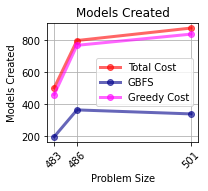

In [34]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [hamming_distance_av_time.get_num_models("Rover/p01.hddl"),
                    hamming_distance_av_time.get_num_models("Rover/p02.hddl"),
                    hamming_distance_av_time.get_num_models("Rover/p03.hddl")
                    ],
                   [hamming_distance_GBFS_av_time.get_num_models("Rover/p01.hddl"),
                    hamming_distance_GBFS_av_time.get_num_models("Rover/p02.hddl"),
                    hamming_distance_GBFS_av_time.get_num_models("Rover/p03.hddl")
                    ],
                   [hamming_distance_GCost_av_time.get_num_models("Rover/p01.hddl"),
                    hamming_distance_GCost_av_time.get_num_models("Rover/p02.hddl"),
                    hamming_distance_GCost_av_time.get_num_models("Rover/p03.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Rover_Hamming_Models.pdf', fig_size=(2.7,2.2))

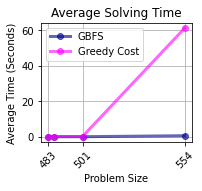

In [35]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl"], ["GBFS", "Greedy Cost"], ["darkblue", "magenta"],
               [
                   [hamming_distance_GBFS_av_time["Rover/p01.hddl"],
                    hamming_distance_GBFS_av_time["Rover/p02.hddl"],
                    hamming_distance_GBFS_av_time["Rover/p03.hddl"],
                    hamming_distance_GBFS_av_time["Rover/p04.hddl"]
                    ],
                   [hamming_distance_GCost_av_time["Rover/p01.hddl"],
                    hamming_distance_GCost_av_time["Rover/p02.hddl"],
                    hamming_distance_GCost_av_time["Rover/p03.hddl"],
                    hamming_distance_GCost_av_time["Rover/p04.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Rover_Hamming_GBFS_GCost.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p03.hddl"], size_dict["Rover/p04.hddl"]])

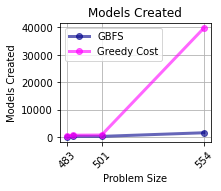

In [36]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl"], ["GBFS", "Greedy Cost"], ["darkblue", "magenta"],
               [
                   [
                    hamming_distance_GBFS_av_time.get_num_models("Rover/p01.hddl"),
                    hamming_distance_GBFS_av_time.get_num_models("Rover/p02.hddl"),
                    hamming_distance_GBFS_av_time.get_num_models("Rover/p03.hddl"),
                    hamming_distance_GBFS_av_time.get_num_models("Rover/p04.hddl")
                    ],
                   [
                    hamming_distance_GCost_av_time.get_num_models("Rover/p01.hddl"),
                    hamming_distance_GCost_av_time.get_num_models("Rover/p02.hddl"),
                    hamming_distance_GCost_av_time.get_num_models("Rover/p03.hddl"),
                    hamming_distance_GCost_av_time.get_num_models("Rover/p04.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Rover_Hamming_GBFS_GCost_Models.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p03.hddl"], size_dict["Rover/p04.hddl"]])

## Graphs for Rover - Tree Distance

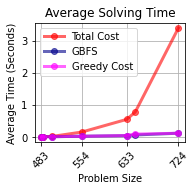

In [37]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl", "Rover/p06.hddl", "Rover/p07.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                    tree_distance_av_time["Rover/p01.hddl"],
                    tree_distance_av_time["Rover/p02.hddl"],
                    tree_distance_av_time["Rover/p03.hddl"],
                    tree_distance_av_time["Rover/p04.hddl"],
                    tree_distance_av_time["Rover/p05.hddl"],
                    tree_distance_av_time["Rover/p06.hddl"],
                    tree_distance_av_time["Rover/p07.hddl"]
                    ],
                   [
                    tree_distance_GBFS_av_time["Rover/p01.hddl"],
                    tree_distance_GBFS_av_time["Rover/p02.hddl"],
                    tree_distance_GBFS_av_time["Rover/p03.hddl"],
                    tree_distance_GBFS_av_time["Rover/p04.hddl"],
                    tree_distance_GBFS_av_time["Rover/p05.hddl"],
                    tree_distance_GBFS_av_time["Rover/p06.hddl"],
                    tree_distance_GBFS_av_time["Rover/p07.hddl"]
                    ],
                   [
                    tree_distance_GCost_av_time["Rover/p01.hddl"],
                    tree_distance_GCost_av_time["Rover/p02.hddl"],
                    tree_distance_GCost_av_time["Rover/p03.hddl"],
                    tree_distance_GCost_av_time["Rover/p04.hddl"],
                    tree_distance_GCost_av_time["Rover/p05.hddl"],
                    tree_distance_GCost_av_time["Rover/p06.hddl"],
                    tree_distance_GCost_av_time["Rover/p07.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Rover_Tree.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p04.hddl"], size_dict["Rover/p05.hddl"], size_dict["Rover/p07.hddl"]])

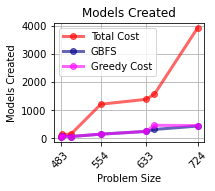

In [38]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl", "Rover/p06.hddl", "Rover/p07.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                       tree_distance_av_time.get_num_models("Rover/p01.hddl"),
                       tree_distance_av_time.get_num_models("Rover/p02.hddl"),
                       tree_distance_av_time.get_num_models("Rover/p03.hddl"),
                       tree_distance_av_time.get_num_models("Rover/p04.hddl"),
                       tree_distance_av_time.get_num_models("Rover/p05.hddl"),
                       tree_distance_av_time.get_num_models("Rover/p06.hddl"),
                       tree_distance_av_time.get_num_models("Rover/p07.hddl")
                   ],
                   [
                       tree_distance_GBFS_av_time.get_num_models("Rover/p01.hddl"),
                       tree_distance_GBFS_av_time.get_num_models("Rover/p02.hddl"),
                       tree_distance_GBFS_av_time.get_num_models("Rover/p03.hddl"),
                       tree_distance_GBFS_av_time.get_num_models("Rover/p04.hddl"),
                       tree_distance_GBFS_av_time.get_num_models("Rover/p05.hddl"),
                       tree_distance_GBFS_av_time.get_num_models("Rover/p06.hddl"),
                       tree_distance_GBFS_av_time.get_num_models("Rover/p07.hddl")
                   ],
                   [
                       tree_distance_GCost_av_time.get_num_models("Rover/p01.hddl"),
                       tree_distance_GCost_av_time.get_num_models("Rover/p02.hddl"),
                       tree_distance_GCost_av_time.get_num_models("Rover/p03.hddl"),
                       tree_distance_GCost_av_time.get_num_models("Rover/p04.hddl"),
                       tree_distance_GCost_av_time.get_num_models("Rover/p05.hddl"),
                       tree_distance_GCost_av_time.get_num_models("Rover/p06.hddl"),
                       tree_distance_GCost_av_time.get_num_models("Rover/p07.hddl")
                   ]
               ], "Models Created", "Models Created", save_name='TO_Rover_Tree_Models.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p04.hddl"], size_dict["Rover/p05.hddl"], size_dict["Rover/p07.hddl"]])

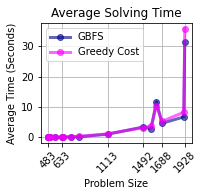

In [39]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl", "Rover/p06.hddl", "Rover/p07.hddl", "Rover/p08.hddl", "Rover/p09.hddl", "Rover/p10.hddl", "Rover/p11.hddl", "Rover/p12.hddl", "Rover/p13.hddl", "Rover/p14.hddl", "Rover/p15.hddl"], ["GBFS", "Greedy Cost"], ["darkblue", "magenta"],
               [
                   [tree_distance_GBFS_av_time["Rover/p01.hddl"],
                    tree_distance_GBFS_av_time["Rover/p02.hddl"],
                    tree_distance_GBFS_av_time["Rover/p03.hddl"],
                    tree_distance_GBFS_av_time["Rover/p04.hddl"],
                    tree_distance_GBFS_av_time["Rover/p05.hddl"],
                    tree_distance_GBFS_av_time["Rover/p06.hddl"],
                    tree_distance_GBFS_av_time["Rover/p07.hddl"],
                    tree_distance_GBFS_av_time["Rover/p08.hddl"],
                    tree_distance_GBFS_av_time["Rover/p09.hddl"],
                    tree_distance_GBFS_av_time["Rover/p10.hddl"],
                    tree_distance_GBFS_av_time["Rover/p11.hddl"],
                    tree_distance_GBFS_av_time["Rover/p12.hddl"],
                    tree_distance_GBFS_av_time["Rover/p13.hddl"],
                    tree_distance_GBFS_av_time["Rover/p14.hddl"],
                    tree_distance_GBFS_av_time["Rover/p15.hddl"]
                    ],
                   [tree_distance_GCost_av_time["Rover/p01.hddl"],
                    tree_distance_GCost_av_time["Rover/p02.hddl"],
                    tree_distance_GCost_av_time["Rover/p03.hddl"],
                    tree_distance_GCost_av_time["Rover/p04.hddl"],
                    tree_distance_GCost_av_time["Rover/p05.hddl"],
                    tree_distance_GCost_av_time["Rover/p06.hddl"],
                    tree_distance_GCost_av_time["Rover/p07.hddl"],
                    tree_distance_GCost_av_time["Rover/p08.hddl"],
                    tree_distance_GCost_av_time["Rover/p09.hddl"],
                    tree_distance_GCost_av_time["Rover/p10.hddl"],
                    tree_distance_GCost_av_time["Rover/p11.hddl"],
                    tree_distance_GCost_av_time["Rover/p12.hddl"],
                    tree_distance_GCost_av_time["Rover/p13.hddl"],
                    tree_distance_GCost_av_time["Rover/p14.hddl"],
                    tree_distance_GCost_av_time["Rover/p15.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Rover_Tree_GBFS_GCost.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p05.hddl"], size_dict["Rover/p09.hddl"], size_dict["Rover/p10.hddl"], size_dict["Rover/p13.hddl"], size_dict["Rover/p15.hddl"]])

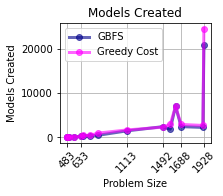

In [40]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl", "Rover/p06.hddl", "Rover/p07.hddl", "Rover/p08.hddl", "Rover/p09.hddl", "Rover/p10.hddl", "Rover/p11.hddl", "Rover/p12.hddl", "Rover/p13.hddl", "Rover/p14.hddl", "Rover/p15.hddl"], ["GBFS", "Greedy Cost"], ["darkblue", "magenta"],
               [
                   [
                    tree_distance_GBFS_av_time.get_num_models("Rover/p01.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p02.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p03.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p04.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p05.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p06.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p07.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p08.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p09.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p10.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p11.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p12.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p13.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p14.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Rover/p15.hddl")
                    ],
                   [
                    tree_distance_GCost_av_time.get_num_models("Rover/p01.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p02.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p03.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p04.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p05.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p06.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p07.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p08.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p09.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p10.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p11.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p12.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p13.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p14.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Rover/p15.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Rover_Tree_GBFS_GCost_Models.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Rover/p01.hddl"], size_dict["Rover/p05.hddl"], size_dict["Rover/p09.hddl"], size_dict["Rover/p10.hddl"], size_dict["Rover/p13.hddl"], size_dict["Rover/p15.hddl"]])

## Graph for Depots - Breadth First

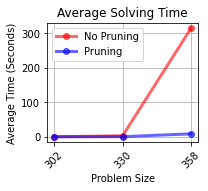

In [41]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl"], ["No Pruning", "Pruning"], ["red", "blue"],
               [
                   [breadth_first_av_time["Depots/p01.hddl"],
                    breadth_first_av_time["Depots/p02.hddl"],
                    breadth_first_av_time["Depots/p03.hddl"]],
                   [breadth_first_pruning_av_time["Depots/p01.hddl"],
                    breadth_first_pruning_av_time["Depots/p02.hddl"],
                    breadth_first_pruning_av_time["Depots/p03.hddl"]]
               ], "Average Solving Time", save_name='TO_Depots_BF_BFP.pdf', fig_size=(2.7,2.2))

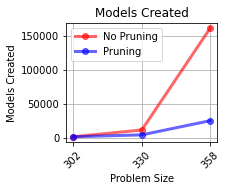

In [42]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl"], ["No Pruning", "Pruning"], ["red", "blue"],
               [
                   [
                    breadth_first_av_time.get_num_models("Depots/p01.hddl"),
                    breadth_first_av_time.get_num_models("Depots/p02.hddl"),
                    breadth_first_av_time.get_num_models("Depots/p03.hddl")
                   ],
                   [
                    breadth_first_pruning_av_time.get_num_models("Depots/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Depots/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Depots/p03.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Depots_BF_BFP_Models.pdf', fig_size=(2.7,2.2))

## Graph for Depots - Delete Relaxed

In [43]:
delete_relaxed_av_time["Depots/p01.hddl"]

12.808388710021973

In [44]:
delete_relaxed_av_time.get_num_models("Depots/p01.hddl")

1347

In [45]:
delete_relaxed_GBFS_av_time["Depots/p01.hddl"]

12.485195493698122

In [46]:
delete_relaxed_GBFS_av_time.get_num_models("Depots/p01.hddl")

567

In [47]:
delete_relaxed_GCost_av_time["Depots/p01.hddl"]

12.710180759429932

In [48]:
delete_relaxed_GCost_av_time.get_num_models("Depots/p01.hddl")

1290

## Graph for Depots - Hamming Distance

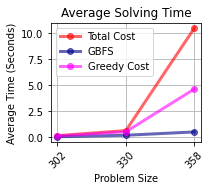

In [192]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                    hamming_distance_av_time["Depots/p01.hddl"],
                    hamming_distance_av_time["Depots/p02.hddl"],
                    hamming_distance_av_time["Depots/p03.hddl"]
                   ],
                   [
                    hamming_distance_GBFS_av_time["Depots/p01.hddl"],
                    hamming_distance_GBFS_av_time["Depots/p02.hddl"],
                    hamming_distance_GBFS_av_time["Depots/p03.hddl"]
                   ],
                   [
                    hamming_distance_GCost_av_time["Depots/p01.hddl"],
                    hamming_distance_GCost_av_time["Depots/p02.hddl"],
                    hamming_distance_GCost_av_time["Depots/p03.hddl"]
                   ]
               ], "Average Solving Time", save_name='TO_Depots_Hamming.pdf', fig_size=(2.7,2.2))

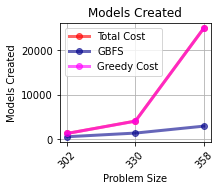

In [191]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                       hamming_distance_av_time.get_num_models("Depots/p01.hddl"),
                       hamming_distance_av_time.get_num_models("Depots/p02.hddl"),
                       hamming_distance_av_time.get_num_models("Depots/p03.hddl")
                   ],
                   [
                       hamming_distance_GBFS_av_time.get_num_models("Depots/p01.hddl"),
                       hamming_distance_GBFS_av_time.get_num_models("Depots/p02.hddl"),
                       hamming_distance_GBFS_av_time.get_num_models("Depots/p03.hddl")
                   ],
                   [
                       hamming_distance_GCost_av_time.get_num_models("Depots/p01.hddl"),
                       hamming_distance_GCost_av_time.get_num_models("Depots/p02.hddl"),
                       hamming_distance_GCost_av_time.get_num_models("Depots/p03.hddl")
                   ]
               ], "Models Created", "Models Created", save_name='TO_Depots_Hamming_Model.pdf', fig_size=(2.7,2.2))

## Graph for Depots - Tree Distance

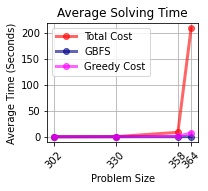

In [190]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl", "Depots/p04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [tree_distance_av_time["Depots/p01.hddl"],
                    tree_distance_av_time["Depots/p02.hddl"],
                    tree_distance_av_time["Depots/p03.hddl"],
                    tree_distance_av_time["Depots/p04.hddl"]
                    ],
                   [tree_distance_GBFS_av_time["Depots/p01.hddl"],
                    tree_distance_GBFS_av_time["Depots/p02.hddl"],
                    tree_distance_GBFS_av_time["Depots/p03.hddl"],
                    tree_distance_GBFS_av_time["Depots/p04.hddl"]
                    ],
                   [tree_distance_GCost_av_time["Depots/p01.hddl"],
                    tree_distance_GCost_av_time["Depots/p02.hddl"],
                    tree_distance_GCost_av_time["Depots/p03.hddl"],
                    tree_distance_GCost_av_time["Depots/p04.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Depots_Tree.pdf', fig_size=(2.7,2.2))

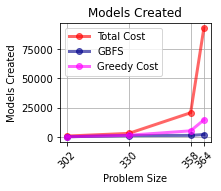

In [189]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl", "Depots/p04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                    tree_distance_av_time.get_num_models("Depots/p01.hddl"),
                    tree_distance_av_time.get_num_models("Depots/p02.hddl"),
                    tree_distance_av_time.get_num_models("Depots/p03.hddl"),
                    tree_distance_av_time.get_num_models("Depots/p04.hddl")
                    ],
                   [
                    tree_distance_GBFS_av_time.get_num_models("Depots/p01.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p02.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p03.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p04.hddl")
                    ],
                   [
                    tree_distance_GCost_av_time.get_num_models("Depots/p01.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p02.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p03.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p04.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='TO_Depots_Tree_Models.pdf', fig_size=(2.7,2.2))

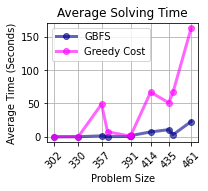

In [53]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p10.hddl", "Depots/p04.hddl", "Depots/p08.hddl", "Depots/p13.hddl", "Depots/p14.hddl", "Depots/p11.hddl", "Depots/p06.hddl", "Depots/p12.hddl"], ["GBFS", "Greedy Cost"], ["darkblue", "magenta"],
               [
                   [tree_distance_GBFS_av_time["Depots/p01.hddl"],
                    tree_distance_GBFS_av_time["Depots/p02.hddl"],
                    tree_distance_GBFS_av_time["Depots/p10.hddl"],
                    tree_distance_GBFS_av_time["Depots/p04.hddl"],
                    tree_distance_GBFS_av_time["Depots/p08.hddl"],
                    tree_distance_GBFS_av_time["Depots/p13.hddl"],
                    tree_distance_GBFS_av_time["Depots/p14.hddl"],
                    tree_distance_GBFS_av_time["Depots/p11.hddl"],
                    tree_distance_GBFS_av_time["Depots/p06.hddl"],
                    tree_distance_GBFS_av_time["Depots/p12.hddl"]
                    ],
                   [tree_distance_GCost_av_time["Depots/p01.hddl"],
                    tree_distance_GCost_av_time["Depots/p02.hddl"],
                    tree_distance_GCost_av_time["Depots/p10.hddl"],
                    tree_distance_GCost_av_time["Depots/p04.hddl"],
                    tree_distance_GCost_av_time["Depots/p08.hddl"],
                    tree_distance_GCost_av_time["Depots/p13.hddl"],
                    tree_distance_GCost_av_time["Depots/p14.hddl"],
                    tree_distance_GCost_av_time["Depots/p11.hddl"],
                    tree_distance_GCost_av_time["Depots/p06.hddl"],
                    tree_distance_GCost_av_time["Depots/p12.hddl"]
                    ]
               ], "Average Solving Time", save_name='TO_Depots_Tree_GBFS_GCost.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Depots/p01.hddl"], size_dict["Depots/p02.hddl"], size_dict["Depots/p10.hddl"], size_dict["Depots/p13.hddl"], size_dict["Depots/p14.hddl"], size_dict["Depots/p11.hddl"], size_dict["Depots/p12.hddl"]])

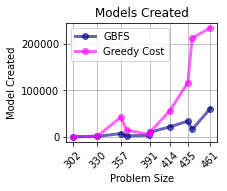

In [54]:
generate_graph(["Depots/p01.hddl", "Depots/p02.hddl", "Depots/p10.hddl", "Depots/p04.hddl", "Depots/p08.hddl", "Depots/p13.hddl", "Depots/p14.hddl", "Depots/p11.hddl", "Depots/p06.hddl", "Depots/p12.hddl"], ["GBFS", "Greedy Cost"], ["darkblue", "magenta"],
               [
                   [
                    tree_distance_GBFS_av_time.get_num_models("Depots/p01.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p02.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p10.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p04.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p08.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p13.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p14.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p11.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p06.hddl"),
                    tree_distance_GBFS_av_time.get_num_models("Depots/p12.hddl")
                    ],
                   [
                    tree_distance_GCost_av_time.get_num_models("Depots/p01.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p02.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p10.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p04.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p08.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p13.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p14.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p11.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p06.hddl"),
                    tree_distance_GCost_av_time.get_num_models("Depots/p12.hddl")
                    ]
               ], "Models Created", "Model Created", save_name='TO_Depots_Tree_GBFS_GCost_Model.pdf', fig_size=(2.7,2.2), xticks=[size_dict["Depots/p01.hddl"], size_dict["Depots/p02.hddl"], size_dict["Depots/p10.hddl"], size_dict["Depots/p13.hddl"], size_dict["Depots/p14.hddl"], size_dict["Depots/p11.hddl"], size_dict["Depots/p12.hddl"]])

## Graph for Factories - Breadth First

In [55]:
breadth_first_av_time["Factories/pfile01.hddl"]

7.096163177490235

In [56]:
breadth_first_av_time.get_num_models("Factories/pfile01.hddl")

14249

In [57]:
breadth_first_pruning_av_time["Factories/pfile01.hddl"]

7.475900077819825

In [58]:
breadth_first_pruning_av_time.get_num_models("Factories/pfile01.hddl")

14249

## Graph for Factories - Delete Relaxed

In [59]:
delete_relaxed_av_time["Factories/pfile01.hddl"]

28.119978141784667

In [60]:
delete_relaxed_av_time.get_num_models("Factories/pfile01.hddl")

9029

This is unable to find a result in a reasonable time

In [61]:
# delete_relaxed_GBFS_av_time["Factories/pfile01.hddl"]

In [62]:
delete_relaxed_GCost_av_time["Factories/pfile01.hddl"]

4.936780166625977

In [63]:
delete_relaxed_GCost_av_time.get_num_models("Factories/pfile01.hddl")

1245

## Graph for Factories - Hamming Distance

In [64]:
hamming_distance_av_time["Factories/pfile01.hddl"]

7.571923017501831

In [65]:
hamming_distance_av_time.get_num_models("Factories/pfile01.hddl")

14249

In [66]:
hamming_distance_GBFS_av_time["Factories/pfile01.hddl"]

7.283648157119751

In [67]:
hamming_distance_GBFS_av_time.get_num_models("Factories/pfile01.hddl")

14249

In [68]:
hamming_distance_GCost_av_time["Factories/pfile01.hddl"]

7.120663070678711

In [69]:
hamming_distance_GCost_av_time.get_num_models("Factories/pfile01.hddl")

14249

## Graph for Factories - Tree Distance

In [70]:
tree_distance_av_time["Factories/pfile01.hddl"]

0.2282588481903076

In [71]:
tree_distance_av_time.get_num_models("Factories/pfile01.hddl")

1717

This unable to get a result in a reasonable time

In [72]:
# tree_distance_GBFS_av_time["Factories/pfile01.hddl"]

In [73]:
tree_distance_GCost_av_time["Factories/pfile01.hddl"]

1.2366250991821288

In [74]:
tree_distance_GCost_av_time.get_num_models("Factories/pfile01.hddl")

7315

## Graph for Translog - Breadth First

In [75]:
breadth_first_av_time["um-translog01/problem.hddl"]

0.13659853935241695

In [76]:
breadth_first_av_time.get_num_models("um-translog01/problem.hddl")

1289

In [77]:
breadth_first_pruning_av_time["um-translog01/problem.hddl"]

0.09989414215087888

In [78]:
breadth_first_pruning_av_time.get_num_models("um-translog01/problem.hddl")

1289

## Graph for Translog - Delete Relaxed

In [79]:
delete_relaxed_av_time["um-translog01/problem.hddl"]

4.687193489074707

In [80]:
delete_relaxed_av_time.get_num_models("um-translog01/problem.hddl")

1395

In [81]:
delete_relaxed_GBFS_av_time["um-translog01/problem.hddl"]

4.102906036376953

In [82]:
delete_relaxed_GBFS_av_time.get_num_models("um-translog01/problem.hddl")

1113

In [83]:
delete_relaxed_GCost_av_time["um-translog01/problem.hddl"]

4.734611082077026

In [84]:
delete_relaxed_GCost_av_time.get_num_models("um-translog01/problem.hddl")

1371

## Graph for Translog - Hamming Distance

In [85]:
hamming_distance_av_time["um-translog01/problem.hddl"]

0.10673894882202144

In [86]:
hamming_distance_av_time.get_num_models("um-translog01/problem.hddl")

1289

In [87]:
hamming_distance_GBFS_av_time["um-translog01/problem.hddl"]

0.10574712753295892

In [88]:
hamming_distance_GBFS_av_time.get_num_models("um-translog01/problem.hddl")

1289

In [89]:
hamming_distance_GCost_av_time["um-translog01/problem.hddl"]

0.15237097740173333

In [90]:
hamming_distance_GCost_av_time.get_num_models("um-translog01/problem.hddl")

1289

## Graph for Translog - Tree Distance

In [91]:
tree_distance_av_time["um-translog01/problem.hddl"]

0.09850554466247556

In [92]:
tree_distance_av_time.get_num_models("um-translog01/problem.hddl")

1289

In [93]:
tree_distance_GBFS_av_time["um-translog01/problem.hddl"]

0.017359876632690358

In [94]:
tree_distance_GBFS_av_time.get_num_models("um-translog01/problem.hddl")

218

In [95]:
tree_distance_GCost_av_time["um-translog01/problem.hddl"]

0.01349105834960934

In [96]:
tree_distance_GCost_av_time.get_num_models("um-translog01/problem.hddl")

218

## Graph for Barman - Breadth First

In [97]:
breadth_first_av_time["Barman/pfile01.hddl"]

5.575131559371949

In [98]:
breadth_first_av_time.get_num_models("Barman/pfile01.hddl")

21845

In [99]:
breadth_first_pruning_av_time["Barman/pfile01.hddl"]

5.70280122756958

In [100]:
breadth_first_pruning_av_time.get_num_models("Barman/pfile01.hddl")

21845

## Graph for Barman - Delete Relaxed

In [101]:
delete_relaxed_av_time["Barman/pfile01.hddl"]

14.694773483276366

In [102]:
delete_relaxed_av_time.get_num_models("Barman/pfile01.hddl")

5074

In [103]:
delete_relaxed_GBFS_av_time["Barman/pfile01.hddl"]

7.970312213897705

In [104]:
delete_relaxed_GBFS_av_time.get_num_models("Barman/pfile01.hddl")

1751

In [105]:
delete_relaxed_GCost_av_time["Barman/pfile01.hddl"]

14.78415217399597

In [106]:
delete_relaxed_GCost_av_time.get_num_models("Barman/pfile01.hddl")

4961

## Graph for Barman - Hamming Distance

In [107]:
hamming_distance_av_time["Barman/pfile01.hddl"]

5.910722112655639

In [108]:
hamming_distance_av_time.get_num_models("Barman/pfile01.hddl")

21845

In [109]:
hamming_distance_GBFS_av_time["Barman/pfile01.hddl"]

5.339926624298096

In [110]:
hamming_distance_GBFS_av_time.get_num_models("Barman/pfile01.hddl")

21845

In [111]:
hamming_distance_GCost_av_time["Barman/pfile01.hddl"]

5.617686605453492

In [112]:
hamming_distance_GCost_av_time.get_num_models("Barman/pfile01.hddl")

21845

## Graph for Barman - Tree Distance

In [113]:
tree_distance_av_time["Barman/pfile01.hddl"]

1.8350982666015625

In [114]:
tree_distance_av_time.get_num_models("Barman/pfile01.hddl")

11433

In [115]:
tree_distance_GBFS_av_time["Barman/pfile01.hddl"]

0.04076967239379878

In [116]:
tree_distance_GBFS_av_time.get_num_models("Barman/pfile01.hddl")

372

In [117]:
tree_distance_GCost_av_time["Barman/pfile01.hddl"]

0.46623907089233396

In [118]:
tree_distance_GCost_av_time.get_num_models("Barman/pfile01.hddl")

3747

# Partial Order Problems

In [119]:
PO_breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Breadth_First_Operations.csv")
PO_breadth_first = pd.read_csv(PO_breadth_first_data_path, sep=",")

PO_breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Breadth_First_Operations.csv")
PO_breadth_first = pd.concat([PO_breadth_first, pd.read_csv(PO_breadth_first_data_path, sep=",")])

PO_breadth_first_av_time = average_time()
for example_name in PO_breadth_first.example_name.unique():

    PO_breadth_first_av_time.calculate_average_time(example_name, PO_breadth_first[PO_breadth_first['example_name'] == example_name]['time_taken'])

    PO_breadth_first_av_time.calculate_average_model(example_name, PO_breadth_first[PO_breadth_first['example_name'] == example_name]['search_models_created'])

PO_breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,5.896934,15141,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
1,Rover/pfile01.hddl,6.348293,15141,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
2,Rover/pfile01.hddl,6.033830,15141,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
3,Rover/pfile01.hddl,5.678689,15141,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
4,Rover/pfile01.hddl,6.241157,15141,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
5,Rover/pfile02.hddl,4.767544,12218,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
6,Rover/pfile02.hddl,4.797302,12218,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
7,Rover/pfile02.hddl,5.338935,12218,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
8,Rover/pfile02.hddl,4.742744,12218,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
9,Rover/pfile02.hddl,5.474839,12218,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...


In [120]:
PO_breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Breadth_First_Operations_PO_Pruning.csv")
PO_breadth_first_pruning = pd.read_csv(PO_breadth_first_pruning_data_path, sep=",")

PO_breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Breadth_First_Operations_PO_Pruning.csv")
PO_breadth_first_pruning = pd.concat([PO_breadth_first_pruning, pd.read_csv(PO_breadth_first_pruning_data_path, sep=",")])

PO_breadth_first_pruning_av_time = average_time()
for example_name in PO_breadth_first_pruning.example_name.unique():

    PO_breadth_first_pruning_av_time.calculate_average_time(example_name, PO_breadth_first_pruning[PO_breadth_first_pruning['example_name'] == example_name]['time_taken'])

    PO_breadth_first_pruning_av_time.calculate_average_model(example_name, PO_breadth_first_pruning[PO_breadth_first_pruning['example_name'] == example_name]['search_models_created'])

PO_breadth_first_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.637855,3417,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
1,Rover/pfile01.hddl,0.600654,3417,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
2,Rover/pfile01.hddl,0.606111,3417,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
3,Rover/pfile01.hddl,0.602637,3417,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
4,Rover/pfile01.hddl,0.601647,3417,serialised_objects\Rover_pfile01hddl_Breadth_F...,serialised_objects\Rover_pfile01hddl_Breadth_F...
5,Rover/pfile02.hddl,0.471695,2515,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
6,Rover/pfile02.hddl,0.734078,2515,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
7,Rover/pfile02.hddl,0.473183,2515,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
8,Rover/pfile02.hddl,0.474670,2515,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...
9,Rover/pfile02.hddl,0.473183,2515,serialised_objects\Rover_pfile02hddl_Breadth_F...,serialised_objects\Rover_pfile02hddl_Breadth_F...


In [121]:
PO_delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Delete_Relaxed_Partial_Order.csv")
PO_delete_relaxed = pd.read_csv(PO_delete_relaxed_data_path, sep=",")

PO_delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Delete_Relaxed_Partial_Order.csv")
PO_delete_relaxed = pd.concat([PO_delete_relaxed, pd.read_csv(PO_delete_relaxed_data_path, sep=",")])

PO_delete_relaxed_av_time = average_time()
for example_name in PO_delete_relaxed.example_name.unique():

    PO_delete_relaxed_av_time.calculate_average_time(example_name, PO_delete_relaxed[PO_delete_relaxed['example_name'] == example_name]['time_taken'])

    PO_delete_relaxed_av_time.calculate_average_model(example_name, PO_delete_relaxed[PO_delete_relaxed['example_name'] == example_name]['search_models_created'])

PO_delete_relaxed

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,26.592003,4079,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
1,Rover/pfile01.hddl,26.384675,4079,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
2,Rover/pfile01.hddl,26.300356,4079,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
3,Rover/pfile01.hddl,26.882658,4079,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
4,Rover/pfile01.hddl,27.055762,4079,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
5,Rover/pfile02.hddl,16.700787,3303,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
6,Rover/pfile02.hddl,17.037571,3303,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
7,Rover/pfile02.hddl,16.846115,3303,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
8,Rover/pfile02.hddl,16.900179,3303,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
9,Rover/pfile02.hddl,16.036645,3303,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...


In [122]:
PO_delete_relaxed_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Delete_Relaxed_Partial_Order_GBFS.csv")
PO_delete_relaxed_GBFS = pd.read_csv(PO_delete_relaxed_GBFS_data_path, sep=",")

PO_delete_relaxed_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Delete_Relaxed_Partial_Order_GBFS.csv")
PO_delete_relaxed_GBFS = pd.concat([PO_delete_relaxed_GBFS, pd.read_csv(PO_delete_relaxed_GBFS_data_path, sep=",")])

PO_delete_relaxed_GBFS_av_time = average_time()
for example_name in PO_delete_relaxed_GBFS.example_name.unique():

    PO_delete_relaxed_GBFS_av_time.calculate_average_time(example_name, PO_delete_relaxed_GBFS[PO_delete_relaxed_GBFS['example_name'] == example_name]['time_taken'])

    PO_delete_relaxed_GBFS_av_time.calculate_average_model(example_name, PO_delete_relaxed_GBFS[PO_delete_relaxed_GBFS['example_name'] == example_name]['search_models_created'])

PO_delete_relaxed_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,2.612427,495,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
1,Rover/pfile01.hddl,2.565804,495,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
2,Rover/pfile01.hddl,2.769163,495,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
3,Rover/pfile01.hddl,2.666491,495,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
4,Rover/pfile01.hddl,2.833643,495,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
5,Rover/pfile02.hddl,4.739769,956,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
6,Rover/pfile02.hddl,4.601880,956,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
7,Rover/pfile02.hddl,4.755143,956,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
8,Rover/pfile02.hddl,4.578072,956,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
9,Rover/pfile02.hddl,4.676776,956,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...


In [123]:
PO_delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Delete_Relaxed_Partial_Order_GCost.csv")
PO_delete_relaxed_GCost = pd.read_csv(PO_delete_relaxed_GCost_data_path, sep=",")

PO_delete_relaxed_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Delete_Relaxed_Partial_Order_GCost.csv")
PO_delete_relaxed_GCost = pd.concat([PO_delete_relaxed_GCost, pd.read_csv(PO_delete_relaxed_GCost_data_path, sep=",")])

PO_delete_relaxed_GCost_av_time = average_time()
for example_name in PO_delete_relaxed_GCost.example_name.unique():

    PO_delete_relaxed_GCost_av_time.calculate_average_time(example_name, PO_delete_relaxed_GCost[PO_delete_relaxed_GCost['example_name'] == example_name]['time_taken'])

    PO_delete_relaxed_GCost_av_time.calculate_average_model(example_name, PO_delete_relaxed_GCost[PO_delete_relaxed_GCost['example_name'] == example_name]['search_models_created'])

PO_delete_relaxed_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,20.225358,3173,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
1,Rover/pfile01.hddl,20.737725,3173,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
2,Rover/pfile01.hddl,20.893965,3173,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
3,Rover/pfile01.hddl,21.061116,3173,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
4,Rover/pfile01.hddl,20.996140,3173,serialised_objects\Rover_pfile01hddl_Delete_Re...,serialised_objects\Rover_pfile01hddl_Delete_Re...
5,Rover/pfile02.hddl,14.073480,2685,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
6,Rover/pfile02.hddl,12.802234,2685,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
7,Rover/pfile02.hddl,12.772475,2685,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
8,Rover/pfile02.hddl,12.920282,2685,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...
9,Rover/pfile02.hddl,13.212922,2685,serialised_objects\Rover_pfile02hddl_Delete_Re...,serialised_objects\Rover_pfile02hddl_Delete_Re...


In [124]:
PO_tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Tree_Distance_Partial_Order.csv")
PO_tree_distance = pd.read_csv(PO_tree_distance_data_path, sep=",")

PO_tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Tree_Distance_Partial_Order.csv")
PO_tree_distance = pd.concat([PO_tree_distance, pd.read_csv(PO_tree_distance_data_path, sep=",")])

PO_tree_distance_av_time = average_time()
for example_name in PO_tree_distance.example_name.unique():

    PO_tree_distance_av_time.calculate_average_time(example_name, PO_tree_distance[PO_tree_distance['example_name'] == example_name]['time_taken'])

    PO_tree_distance_av_time.calculate_average_model(example_name, PO_tree_distance[PO_tree_distance['example_name'] == example_name]['search_models_created'])

PO_tree_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.284703,1534,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
1,Rover/pfile01.hddl,0.235103,1534,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
2,Rover/pfile01.hddl,0.228159,1534,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
3,Rover/pfile01.hddl,0.259407,1534,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
4,Rover/pfile01.hddl,0.213279,1534,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
5,Rover/pfile02.hddl,0.072912,632,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
6,Rover/pfile02.hddl,0.072912,632,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
7,Rover/pfile02.hddl,0.072911,632,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
8,Rover/pfile02.hddl,0.098207,632,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
9,Rover/pfile02.hddl,0.071919,632,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...


In [125]:
PO_tree_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Tree_Distance_Partial_Order_GBFS.csv")
PO_tree_distance_GBFS = pd.read_csv(PO_tree_distance_GBFS_data_path, sep=",")

PO_tree_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Tree_Distance_Partial_Order_GBFS.csv")
PO_tree_distance_GBFS = pd.concat([PO_tree_distance_GBFS, pd.read_csv(PO_tree_distance_GBFS_data_path, sep=",")])

PO_tree_distance_GBFS_av_time = average_time()
for example_name in PO_tree_distance_GBFS.example_name.unique():

    PO_tree_distance_GBFS_av_time.calculate_average_time(example_name, PO_tree_distance_GBFS[PO_tree_distance_GBFS['example_name'] == example_name]['time_taken'])

    PO_tree_distance_GBFS_av_time.calculate_average_model(example_name, PO_tree_distance_GBFS[PO_tree_distance_GBFS['example_name'] == example_name]['search_models_created'])

PO_tree_distance_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.009424,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
1,Rover/pfile01.hddl,0.012896,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
2,Rover/pfile01.hddl,0.013392,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
3,Rover/pfile01.hddl,0.009920,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
4,Rover/pfile01.hddl,0.010416,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
5,Rover/pfile02.hddl,0.005952,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
6,Rover/pfile02.hddl,0.004463,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
7,Rover/pfile02.hddl,0.003968,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
8,Rover/pfile02.hddl,0.004463,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
9,Rover/pfile02.hddl,0.004463,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...


In [126]:
PO_tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Tree_Distance_Partial_Order_GCost.csv")
PO_tree_distance_GCost = pd.read_csv(PO_tree_distance_GCost_data_path, sep=",")

PO_tree_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Tree_Distance_Partial_Order_GCost.csv")
PO_tree_distance_GCost = pd.concat([PO_tree_distance_GCost, pd.read_csv(PO_tree_distance_GCost_data_path, sep=",")])

PO_tree_distance_GCost_av_time = average_time()
for example_name in PO_tree_distance_GCost.example_name.unique():

    PO_tree_distance_GCost_av_time.calculate_average_time(example_name, PO_tree_distance_GCost[PO_tree_distance_GCost['example_name'] == example_name]['time_taken'])

    PO_tree_distance_GCost_av_time.calculate_average_model(example_name, PO_tree_distance_GCost[PO_tree_distance_GCost['example_name'] == example_name]['search_models_created'])

PO_tree_distance_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.010416,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
1,Rover/pfile01.hddl,0.010416,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
2,Rover/pfile01.hddl,0.009920,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
3,Rover/pfile01.hddl,0.009423,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
4,Rover/pfile01.hddl,0.010415,100,serialised_objects\Rover_pfile01hddl_Tree_Dist...,serialised_objects\Rover_pfile01hddl_Tree_Dist...
5,Rover/pfile02.hddl,0.004464,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
6,Rover/pfile02.hddl,0.003968,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
7,Rover/pfile02.hddl,0.004463,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
8,Rover/pfile02.hddl,0.004463,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...
9,Rover/pfile02.hddl,0.004464,45,serialised_objects\Rover_pfile02hddl_Tree_Dist...,serialised_objects\Rover_pfile02hddl_Tree_Dist...


In [127]:
PO_hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Hamming_Distance_Partial_Order.csv")
PO_hamming_distance = pd.read_csv(PO_hamming_distance_data_path, sep=",")

PO_hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Hamming_Distance_Partial_Order.csv")
PO_hamming_distance = pd.concat([PO_hamming_distance, pd.read_csv(PO_hamming_distance_data_path, sep=",")])

PO_hamming_distance_av_time = average_time()
for example_name in PO_hamming_distance.example_name.unique():

    PO_hamming_distance_av_time.calculate_average_time(example_name, PO_hamming_distance[PO_hamming_distance['example_name'] == example_name]['time_taken'])

    PO_hamming_distance_av_time.calculate_average_model(example_name, PO_hamming_distance[PO_hamming_distance['example_name'] == example_name]['search_models_created'])

PO_hamming_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.630911,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
1,Rover/pfile01.hddl,0.616527,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
2,Rover/pfile01.hddl,0.608591,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
3,Rover/pfile01.hddl,0.604126,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
4,Rover/pfile01.hddl,0.701839,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
5,Rover/pfile02.hddl,0.477647,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
6,Rover/pfile02.hddl,0.478143,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
7,Rover/pfile02.hddl,0.472191,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
8,Rover/pfile02.hddl,0.471695,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
9,Rover/pfile02.hddl,0.474174,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...


In [128]:
PO_hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Hamming_Distance_Partial_Order_GBFS.csv")
PO_hamming_distance_GBFS = pd.read_csv(PO_hamming_distance_GBFS_data_path, sep=",")

PO_hamming_distance_GBFS_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Hamming_Distance_Partial_Order_GBFS.csv")
PO_hamming_distance_GBFS = pd.concat([PO_hamming_distance_GBFS, pd.read_csv(PO_hamming_distance_GBFS_data_path, sep=",")])

PO_hamming_distance_GBFS_av_time = average_time()
for example_name in PO_hamming_distance_GBFS.example_name.unique():

    PO_hamming_distance_GBFS_av_time.calculate_average_time(example_name, PO_hamming_distance_GBFS[PO_hamming_distance_GBFS['example_name'] == example_name]['time_taken'])

    PO_hamming_distance_GBFS_av_time.calculate_average_model(example_name, PO_hamming_distance_GBFS[PO_hamming_distance_GBFS['example_name'] == example_name]['search_models_created'])

PO_hamming_distance_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.623471,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
1,Rover/pfile01.hddl,0.611071,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
2,Rover/pfile01.hddl,0.617519,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
3,Rover/pfile01.hddl,0.623967,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
4,Rover/pfile01.hddl,0.619502,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
5,Rover/pfile02.hddl,0.480623,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
6,Rover/pfile02.hddl,0.478143,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
7,Rover/pfile02.hddl,0.476159,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
8,Rover/pfile02.hddl,0.478144,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
9,Rover/pfile02.hddl,0.480127,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...


In [129]:
PO_hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Rover_Partial_Order", "Hamming_Distance_Partial_Order_GCost.csv")
PO_hamming_distance_GCost = pd.read_csv(PO_hamming_distance_GCost_data_path, sep=",")

PO_hamming_distance_GCost_data_path = os.path.join(os.getcwd(), "Archive", "Barman_Partial_Order", "Hamming_Distance_Partial_Order_GCost.csv")
PO_hamming_distance_GCost = pd.concat([PO_hamming_distance_GCost, pd.read_csv(PO_hamming_distance_GCost_data_path, sep=",")])

PO_hamming_distance_GCost_av_time = average_time()
for example_name in PO_hamming_distance_GCost.example_name.unique():

    PO_hamming_distance_GCost_av_time.calculate_average_time(example_name, PO_hamming_distance_GCost[PO_hamming_distance_GCost['example_name'] == example_name]['time_taken'])

    PO_hamming_distance_GCost_av_time.calculate_average_model(example_name, PO_hamming_distance_GCost[PO_hamming_distance_GCost['example_name'] == example_name]['search_models_created'])

PO_hamming_distance_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/pfile01.hddl,0.630911,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
1,Rover/pfile01.hddl,0.623967,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
2,Rover/pfile01.hddl,0.615535,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
3,Rover/pfile01.hddl,0.690429,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
4,Rover/pfile01.hddl,0.622975,3417,serialised_objects\Rover_pfile01hddl_Hamming_D...,serialised_objects\Rover_pfile01hddl_Hamming_D...
5,Rover/pfile02.hddl,0.482607,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
6,Rover/pfile02.hddl,0.487071,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
7,Rover/pfile02.hddl,0.485087,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
8,Rover/pfile02.hddl,0.484095,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...
9,Rover/pfile02.hddl,0.487567,2515,serialised_objects\Rover_pfile02hddl_Hamming_D...,serialised_objects\Rover_pfile02hddl_Hamming_D...


## Graph for PO Rover - Breadth First

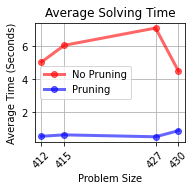

In [130]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["No Pruning", "Pruning"], ["red", "blue"],
               [
                   [PO_breadth_first_av_time["Rover/pfile02.hddl"],
                    PO_breadth_first_av_time["Rover/pfile01.hddl"],
                    PO_breadth_first_av_time["Rover/pfile03.hddl"],
                    PO_breadth_first_av_time["Rover/pfile04.hddl"]
                    ],
                   [PO_breadth_first_pruning_av_time["Rover/pfile02.hddl"],
                    PO_breadth_first_pruning_av_time["Rover/pfile01.hddl"],
                    PO_breadth_first_pruning_av_time["Rover/pfile03.hddl"],
                    PO_breadth_first_pruning_av_time["Rover/pfile04.hddl"]
                    ]
               ], "Average Solving Time", save_name='PO_Rover_BF_BFP.pdf', fig_size=(2.7,2.2))

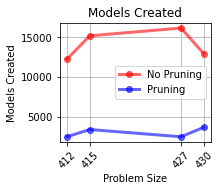

In [131]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["No Pruning", "Pruning"], ["red", "blue"],
               [
                   [
                    PO_breadth_first_av_time.get_num_models("Rover/pfile02.hddl"),
                    PO_breadth_first_av_time.get_num_models("Rover/pfile01.hddl"),
                    PO_breadth_first_av_time.get_num_models("Rover/pfile03.hddl"),
                    PO_breadth_first_av_time.get_num_models("Rover/pfile04.hddl")
                    ],
                   [
                    PO_breadth_first_pruning_av_time.get_num_models("Rover/pfile02.hddl"),
                    PO_breadth_first_pruning_av_time.get_num_models("Rover/pfile01.hddl"),
                    PO_breadth_first_pruning_av_time.get_num_models("Rover/pfile03.hddl"),
                    PO_breadth_first_pruning_av_time.get_num_models("Rover/pfile04.hddl")
                    ]
               ], "Models Created", "Models Created", save_name='PO_Rover_BF_BFP_Models.pdf', fig_size=(2.7,2.2))

## Graph for PO Rover - Delete Relaxed

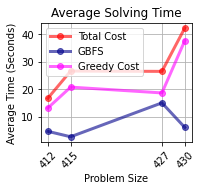

In [193]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red","darkblue", "magenta"],
               [
                   [
                       PO_delete_relaxed_av_time["Rover/pfile02.hddl"],
                       PO_delete_relaxed_av_time["Rover/pfile01.hddl"],
                       PO_delete_relaxed_av_time["Rover/pfile03.hddl"],
                       PO_delete_relaxed_av_time["Rover/pfile04.hddl"]
                   ],
                   [
                       PO_delete_relaxed_GBFS_av_time["Rover/pfile02.hddl"],
                       PO_delete_relaxed_GBFS_av_time["Rover/pfile01.hddl"],
                       PO_delete_relaxed_GBFS_av_time["Rover/pfile03.hddl"],
                       PO_delete_relaxed_GBFS_av_time["Rover/pfile04.hddl"]
                   ],
                   [
                       PO_delete_relaxed_GCost_av_time["Rover/pfile02.hddl"],
                       PO_delete_relaxed_GCost_av_time["Rover/pfile01.hddl"],
                       PO_delete_relaxed_GCost_av_time["Rover/pfile03.hddl"],
                       PO_delete_relaxed_GCost_av_time["Rover/pfile04.hddl"]
                   ]
               ], "Average Solving Time", save_name='PO_Rover_DR.pdf', fig_size=(2.7,2.2))

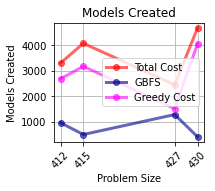

In [133]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red","darkblue", "magenta"],
               [
                   [
                       PO_delete_relaxed_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_delete_relaxed_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_delete_relaxed_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_delete_relaxed_av_time.get_num_models("Rover/pfile04.hddl")
                   ],
                   [
                       PO_delete_relaxed_GBFS_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_delete_relaxed_GBFS_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_delete_relaxed_GBFS_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_delete_relaxed_GBFS_av_time.get_num_models("Rover/pfile04.hddl")
                   ],
                   [
                       PO_delete_relaxed_GCost_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_delete_relaxed_GCost_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_delete_relaxed_GCost_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_delete_relaxed_GCost_av_time.get_num_models("Rover/pfile04.hddl")
                   ]
               ], "Models Created", "Models Created", save_name='PO_Rover_DR_Models.pdf', fig_size=(2.7,2.2))

## Graph for PO Rover - Hamming Distance

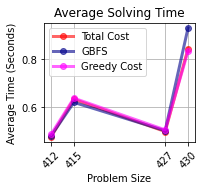

In [134]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red","darkblue", "magenta"],
               [
                   [
                    PO_hamming_distance_av_time["Rover/pfile02.hddl"],
                    PO_hamming_distance_av_time["Rover/pfile01.hddl"],
                    PO_hamming_distance_av_time["Rover/pfile03.hddl"],
                    PO_hamming_distance_av_time["Rover/pfile04.hddl"]
                    ],
                   [
                       PO_hamming_distance_GBFS_av_time["Rover/pfile02.hddl"],
                       PO_hamming_distance_GBFS_av_time["Rover/pfile01.hddl"],
                       PO_hamming_distance_GBFS_av_time["Rover/pfile03.hddl"],
                       PO_hamming_distance_GBFS_av_time["Rover/pfile04.hddl"]
                   ],
                   [
                       PO_hamming_distance_GCost_av_time["Rover/pfile02.hddl"],
                       PO_hamming_distance_GCost_av_time["Rover/pfile01.hddl"],
                       PO_hamming_distance_GCost_av_time["Rover/pfile03.hddl"],
                       PO_hamming_distance_GCost_av_time["Rover/pfile04.hddl"]
                   ]
               ], "Average Solving Time", save_name='PO_Rover_HM.pdf', fig_size=(2.7,2.2))

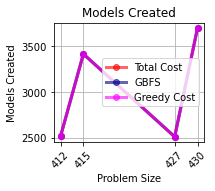

In [135]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red","darkblue", "magenta"],
               [
                   [
                       PO_hamming_distance_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_hamming_distance_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_hamming_distance_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_hamming_distance_av_time.get_num_models("Rover/pfile04.hddl")
                   ],
                   [
                       PO_hamming_distance_GBFS_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_hamming_distance_GBFS_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_hamming_distance_GBFS_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_hamming_distance_GBFS_av_time.get_num_models("Rover/pfile04.hddl")
                   ],
                   [
                       PO_hamming_distance_GCost_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_hamming_distance_GCost_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_hamming_distance_GCost_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_hamming_distance_GCost_av_time.get_num_models("Rover/pfile04.hddl")
                   ]
               ], "Models Created", "Models Created", save_name='PO_Rover_HM_Models.pdf', fig_size=(2.7,2.2))

## Graph for PO Rover - Tree Distance

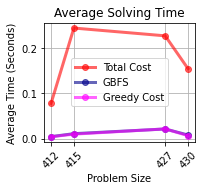

In [136]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red","darkblue", "magenta"],
               [
                   [
                       PO_tree_distance_av_time["Rover/pfile02.hddl"],
                       PO_tree_distance_av_time["Rover/pfile01.hddl"],
                       PO_tree_distance_av_time["Rover/pfile03.hddl"],
                       PO_tree_distance_av_time["Rover/pfile04.hddl"]
                   ],
                   [
                       PO_tree_distance_GBFS_av_time["Rover/pfile02.hddl"],
                       PO_tree_distance_GBFS_av_time["Rover/pfile01.hddl"],
                       PO_tree_distance_GBFS_av_time["Rover/pfile03.hddl"],
                       PO_tree_distance_GBFS_av_time["Rover/pfile04.hddl"]
                   ],
                   [
                       PO_tree_distance_GCost_av_time["Rover/pfile02.hddl"],
                       PO_tree_distance_GCost_av_time["Rover/pfile01.hddl"],
                       PO_tree_distance_GCost_av_time["Rover/pfile03.hddl"],
                       PO_tree_distance_GCost_av_time["Rover/pfile04.hddl"]
                   ]
               ], "Average Solving Time", save_name='PO_Rover_Tree.pdf', fig_size=(2.7,2.2))

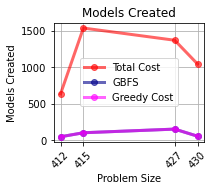

In [137]:
generate_graph(["Rover/pfile02.hddl", "Rover/pfile01.hddl", "Rover/pfile03.hddl", "Rover/pfile04.hddl"], ["Total Cost", "GBFS", "Greedy Cost"], ["red","darkblue", "magenta"],
               [
                   [
                       PO_tree_distance_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_tree_distance_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_tree_distance_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_tree_distance_av_time.get_num_models("Rover/pfile04.hddl")
                   ],
                   [
                       PO_tree_distance_GBFS_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_tree_distance_GBFS_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_tree_distance_GBFS_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_tree_distance_GBFS_av_time.get_num_models("Rover/pfile04.hddl")
                   ],
                   [
                       PO_tree_distance_GCost_av_time.get_num_models("Rover/pfile02.hddl"),
                       PO_tree_distance_GCost_av_time.get_num_models("Rover/pfile01.hddl"),
                       PO_tree_distance_GCost_av_time.get_num_models("Rover/pfile03.hddl"),
                       PO_tree_distance_GCost_av_time.get_num_models("Rover/pfile04.hddl")
                   ]
               ], "Models Created", "Models Created", save_name='PO_Rover_Tree_Models.pdf', fig_size=(2.7,2.2))

## Graph for PO Barman - Breadth First

In [138]:
PO_breadth_first_av_time["Barman/pfile01.hddl"]

5.58376178741455

In [139]:
PO_breadth_first_av_time.get_num_models("Barman/pfile01.hddl")

16280

In [140]:
PO_breadth_first_pruning_av_time["Barman/pfile01.hddl"]

5.6889135360717775

In [141]:
PO_breadth_first_pruning_av_time.get_num_models("Barman/pfile01.hddl")

16280

## Graph for PO Barman - Delete Relaxed

In [142]:
PO_delete_relaxed_av_time["Barman/pfile01.hddl"]

14.574042320251465

In [143]:
PO_delete_relaxed_av_time.get_num_models("Barman/pfile01.hddl")

4030

In [144]:
PO_delete_relaxed_GBFS_av_time["Barman/pfile01.hddl"]

7.773894453048706

In [145]:
PO_delete_relaxed_GBFS_av_time.get_num_models("Barman/pfile01.hddl")

1386

In [146]:
PO_delete_relaxed_GCost_av_time["Barman/pfile01.hddl"]

14.0874671459198

In [147]:
PO_delete_relaxed_GCost_av_time.get_num_models("Barman/pfile01.hddl")

3917

## Graph for PO Barman - Hamming Distance

In [148]:
PO_hamming_distance_av_time["Barman/pfile01.hddl"]

5.4095649242401125

In [149]:
PO_hamming_distance_av_time.get_num_models("Barman/pfile01.hddl")

16280

In [150]:
PO_hamming_distance_GBFS_av_time["Barman/pfile01.hddl"]

5.381193685531616

In [151]:
PO_hamming_distance_GBFS_av_time.get_num_models("Barman/pfile01.hddl")

16280

In [152]:
PO_hamming_distance_GCost_av_time["Barman/pfile01.hddl"]

6.092952537536621

In [153]:
PO_hamming_distance_GCost_av_time.get_num_models("Barman/pfile01.hddl")

16280

## Graph for PO Barman - Tree Distance

In [154]:
PO_tree_distance_av_time["Barman/pfile01.hddl"]

1.756729745864868

In [155]:
PO_tree_distance_av_time.get_num_models("Barman/pfile01.hddl")

8497

In [156]:
PO_tree_distance_GBFS_av_time["Barman/pfile01.hddl"]

0.044540596008300744

In [157]:
PO_tree_distance_GBFS_av_time.get_num_models("Barman/pfile01.hddl")

309

In [158]:
PO_tree_distance_GCost_av_time["Barman/pfile01.hddl"]

0.45235133171081543

In [159]:
PO_tree_distance_GCost_av_time.get_num_models("Barman/pfile01.hddl")

3188

# JSHOP Problems

In [160]:
HDDL_Parse_data_path = os.path.join(os.getcwd(), "Archive", "HDDL_JSHOP_Rover", "Breadth_First_HDDL.csv")
HDDL_Parse = pd.read_csv(HDDL_Parse_data_path, sep=",")

HDDL_Parse_data_path = os.path.join(os.getcwd(), "Archive", "Basic", "HDDL_Parsing.csv")
HDDL_Parse = pd.concat([HDDL_Parse, pd.read_csv(HDDL_Parse_data_path, sep=",")])

HDDL_Parse_av_time = average_time()
for example_name in HDDL_Parse.example_name.unique():

    HDDL_Parse_av_time.calculate_average_time(example_name, HDDL_Parse[HDDL_Parse['example_name'] == example_name]['time_taken'])

    HDDL_Parse_av_time.calculate_average_model(example_name, HDDL_Parse[HDDL_Parse['example_name'] == example_name]['search_models_created'])

HDDL_Parse

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.002480,0,NONE,NONE
1,Rover/p01.hddl,0.003472,0,NONE,NONE
2,Rover/p01.hddl,0.002976,0,NONE,NONE
3,Rover/p01.hddl,0.002480,0,NONE,NONE
4,Rover/p01.hddl,0.002480,0,NONE,NONE
5,Rover/p02.hddl,0.002976,0,NONE,NONE
6,Rover/p02.hddl,0.002479,0,NONE,NONE
7,Rover/p02.hddl,0.002976,0,NONE,NONE
8,Rover/p02.hddl,0.002480,0,NONE,NONE
9,Rover/p02.hddl,0.003472,0,NONE,NONE


In [161]:
HDDL_Solve_data_path = os.path.join(os.getcwd(), "Archive", "Basic", "Breadth_First_HDDL.csv")
HDDL_Solve_bf = pd.read_csv(HDDL_Solve_data_path, sep=",")

HDDL_Solve_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations.csv")
HDDL_Solve_bf = pd.concat([HDDL_Solve_bf, pd.read_csv(HDDL_Solve_data_path, sep=",")])

HDDL_Solve_bf_av_time = average_time()
for example_name in HDDL_Solve_bf.example_name.unique():

    HDDL_Solve_bf_av_time.calculate_average_time(example_name, HDDL_Solve_bf[HDDL_Solve_bf['example_name'] == example_name]['time_taken'])

    HDDL_Solve_bf_av_time.calculate_average_model(example_name, HDDL_Solve_bf[HDDL_Solve_bf['example_name'] == example_name]['search_models_created'])

HDDL_Solve_bf

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Basic/pb1.hddl,0.000000,3,serialised_objects\Basic_pb1hddl_Breadth_First...,serialised_objects\Basic_pb1hddl_Breadth_First...
1,Basic/pb1.hddl,0.000000,3,serialised_objects\Basic_pb1hddl_Breadth_First...,serialised_objects\Basic_pb1hddl_Breadth_First...
2,Basic/pb1.hddl,0.000496,3,serialised_objects\Basic_pb1hddl_Breadth_First...,serialised_objects\Basic_pb1hddl_Breadth_First...
3,Basic/pb1.hddl,0.000000,3,serialised_objects\Basic_pb1hddl_Breadth_First...,serialised_objects\Basic_pb1hddl_Breadth_First...
4,Basic/pb1.hddl,0.000000,3,serialised_objects\Basic_pb1hddl_Breadth_First...,serialised_objects\Basic_pb1hddl_Breadth_First...
0,Rover/p01.hddl,0.406223,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.405728,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.452351,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.403743,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.406224,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...


In [162]:
JSHOP_Parse_data_path = os.path.join(os.getcwd(), "Archive", "HDDL_JSHOP_Rover", "Breadth_First_JSHOP.csv")
JSHOP_Parse = pd.read_csv(JSHOP_Parse_data_path, sep=",")

JSHOP_Parse_data_path = os.path.join(os.getcwd(), "Archive", "Basic", "JSHOP_Parsing.csv")
JSHOP_Parse = pd.concat([JSHOP_Parse, pd.read_csv(JSHOP_Parse_data_path, sep=",")])

JSHOP_Parse_av_time = average_time()
for example_name in JSHOP_Parse.example_name.unique():

    JSHOP_Parse_av_time.calculate_average_time(example_name, JSHOP_Parse[JSHOP_Parse['example_name'] == example_name]['time_taken'])

    JSHOP_Parse_av_time.calculate_average_model(example_name, JSHOP_Parse[JSHOP_Parse['example_name'] == example_name]['search_models_created'])

JSHOP_Parse

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.054064,0,NONE,NONE
1,rover/pb1.jshop,0.002976,0,NONE,NONE
2,rover/pb1.jshop,0.003472,0,NONE,NONE
3,rover/pb1.jshop,0.002976,0,NONE,NONE
4,rover/pb1.jshop,0.003968,0,NONE,NONE
5,rover/pb2.jshop,0.014880,0,NONE,NONE
6,rover/pb2.jshop,0.002976,0,NONE,NONE
7,rover/pb2.jshop,0.002976,0,NONE,NONE
8,rover/pb2.jshop,0.003472,0,NONE,NONE
9,rover/pb2.jshop,0.002480,0,NONE,NONE


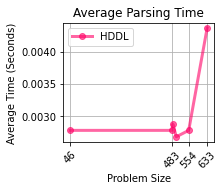

In [163]:
generate_graph(["Basic/pb1.hddl", "Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl"],
               ["HDDL"], ["#ff0066"],
               [
                   [
                       HDDL_Parse_av_time["Basic/pb1.hddl"],
                       HDDL_Parse_av_time["Rover/p01.hddl"],
                       HDDL_Parse_av_time["Rover/p02.hddl"],
                       HDDL_Parse_av_time["Rover/p03.hddl"],
                       HDDL_Parse_av_time["Rover/p04.hddl"],
                       HDDL_Parse_av_time["Rover/p05.hddl"]
                   ]
               ], "Average Parsing Time", fig_size=(2.7,2.2), xticks=[size_dict["Basic/pb1.hddl"], size_dict["Rover/p01.hddl"], size_dict["Rover/p04.hddl"], size_dict["Rover/p05.hddl"]], save_name="HDDL_Parse_Time.pdf")

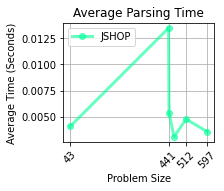

In [164]:
generate_graph(["basic/problem.jshop", "rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop", "rover/pb4.jshop", "rover/pb5.jshop"],
               ["JSHOP"], ["#00ff99"],
               [
                   [
                       JSHOP_Parse_av_time["basic/problem.jshop"],
                       JSHOP_Parse_av_time["rover/pb1.jshop"],
                       JSHOP_Parse_av_time["rover/pb2.jshop"],
                       JSHOP_Parse_av_time["rover/pb3.jshop"],
                       JSHOP_Parse_av_time["rover/pb4.jshop"],
                       JSHOP_Parse_av_time["rover/pb5.jshop"]
                   ]
               ], "Average Parsing Time", fig_size=(2.7,2.2), xticks=[size_dict["basic/problem.jshop"], size_dict["rover/pb1.jshop"], size_dict["rover/pb4.jshop"], size_dict["rover/pb5.jshop"]], save_name="JSHOP_Parse_Time.pdf")

In [194]:
hddl = HDDL_Parse[HDDL_Parse['example_name'] == "Basic/pb1.hddl"]['time_taken']
jshop = JSHOP_Parse[JSHOP_Parse['example_name'] == "basic/problem.jshop"]['time_taken']

print("Basic pb1 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Basic pb1 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.7425854523588444


In [195]:
hddl = HDDL_Parse[HDDL_Parse['example_name'] == "Rover/p01.hddl"]['time_taken']
jshop = JSHOP_Parse[JSHOP_Parse['example_name'] == "rover/pb1.jshop"]['time_taken']

print("Rover pb1 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Rover pb1 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.32187229767941133


In [196]:
hddl = HDDL_Parse[HDDL_Parse['example_name'] == "Rover/p02.hddl"]['time_taken']
jshop = JSHOP_Parse[JSHOP_Parse['example_name'] == "rover/pb2.jshop"]['time_taken']

print("Rover pb2 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Rover pb2 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.33032711280610955


In [197]:
hddl = HDDL_Parse[HDDL_Parse['example_name'] == "Rover/p03.hddl"]['time_taken']
jshop = JSHOP_Parse[JSHOP_Parse['example_name'] == "rover/pb3.jshop"]['time_taken']

print("Rover pb3 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Rover pb3 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.577533399853664


In [198]:
hddl = HDDL_Parse[HDDL_Parse['example_name'] == "Rover/p04.hddl"]['time_taken']
jshop = JSHOP_Parse[JSHOP_Parse['example_name'] == "rover/pb4.jshop"]['time_taken']

print("Rover pb4 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Rover pb4 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.36061753858112183


In [199]:
hddl = HDDL_Parse[HDDL_Parse['example_name'] == "Rover/p05.hddl"]['time_taken']
jshop = JSHOP_Parse[JSHOP_Parse['example_name'] == "rover/pb5.jshop"]['time_taken']

print("Rover pb5 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Rover pb5 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.5209017171221705


## JSHOP Solve Times

In [165]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "Basic", "Breadth_First_JSHOP.csv")
JSHOP_Solve_bf = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Breadth_First.csv")
JSHOP_Solve_bf = pd.concat([JSHOP_Solve_bf, pd.read_csv(JSHOP_Solve_data_path, sep=",")])

JSHOP_Solve_bf_av_time = average_time()
for example_name in JSHOP_Solve_bf.example_name.unique():

    JSHOP_Solve_bf_av_time.calculate_average_time(example_name, JSHOP_Solve_bf[JSHOP_Solve_bf['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_bf_av_time.calculate_average_model(example_name, JSHOP_Solve_bf[JSHOP_Solve_bf['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_bf

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,basic/problem.jshop,0.000495,3,serialised_objects\basic_problemjshop_Breadth_...,serialised_objects\basic_problemjshop_Breadth_...
1,basic/problem.jshop,0.001983,3,serialised_objects\basic_problemjshop_Breadth_...,serialised_objects\basic_problemjshop_Breadth_...
2,basic/problem.jshop,0.000000,3,serialised_objects\basic_problemjshop_Breadth_...,serialised_objects\basic_problemjshop_Breadth_...
3,basic/problem.jshop,0.000496,3,serialised_objects\basic_problemjshop_Breadth_...,serialised_objects\basic_problemjshop_Breadth_...
4,basic/problem.jshop,0.000000,3,serialised_objects\basic_problemjshop_Breadth_...,serialised_objects\basic_problemjshop_Breadth_...
0,rover/pb1.jshop,50.580027,36086,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
1,rover/pb1.jshop,49.403020,36086,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
2,rover/pb1.jshop,48.803357,36086,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
3,rover/pb1.jshop,48.091599,36086,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
4,rover/pb1.jshop,48.709117,36086,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...


In [166]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Breadth_First_Pruning.csv")
JSHOP_Solve_bf_pruning = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_bf_pruning_av_time = average_time()
for example_name in JSHOP_Solve_bf_pruning.example_name.unique():

    JSHOP_Solve_bf_pruning_av_time.calculate_average_time(example_name, JSHOP_Solve_bf_pruning[JSHOP_Solve_bf_pruning['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_bf_pruning_av_time.calculate_average_model(example_name, JSHOP_Solve_bf_pruning[JSHOP_Solve_bf_pruning['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_bf_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.359103,1564,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
1,rover/pb1.jshop,0.693406,1564,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
2,rover/pb1.jshop,0.368527,1564,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
3,rover/pb1.jshop,0.361087,1564,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
4,rover/pb1.jshop,0.369023,1564,serialised_objects\rover_pb1jshop_Breadth_Firs...,serialised_objects\rover_pb1jshop_Breadth_Firs...
5,rover/pb2.jshop,0.666623,2909,serialised_objects\rover_pb2jshop_Breadth_Firs...,serialised_objects\rover_pb2jshop_Breadth_Firs...
6,rover/pb2.jshop,0.742015,2909,serialised_objects\rover_pb2jshop_Breadth_Firs...,serialised_objects\rover_pb2jshop_Breadth_Firs...
7,rover/pb2.jshop,0.673567,2909,serialised_objects\rover_pb2jshop_Breadth_Firs...,serialised_objects\rover_pb2jshop_Breadth_Firs...
8,rover/pb2.jshop,0.670591,2909,serialised_objects\rover_pb2jshop_Breadth_Firs...,serialised_objects\rover_pb2jshop_Breadth_Firs...
9,rover/pb2.jshop,0.667120,2909,serialised_objects\rover_pb2jshop_Breadth_Firs...,serialised_objects\rover_pb2jshop_Breadth_Firs...


In [167]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Tree_Distance.csv")
JSHOP_Solve_tree = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_tree_av_time = average_time()
for example_name in JSHOP_Solve_tree.example_name.unique():

    JSHOP_Solve_tree_av_time.calculate_average_time(example_name, JSHOP_Solve_tree[JSHOP_Solve_tree['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_tree_av_time.calculate_average_model(example_name, JSHOP_Solve_tree[JSHOP_Solve_tree['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_tree

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.234111,1023,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
1,rover/pb1.jshop,0.228160,1023,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
2,rover/pb1.jshop,0.231135,1023,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
3,rover/pb1.jshop,0.760367,1023,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
4,rover/pb1.jshop,0.234111,1023,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
5,rover/pb2.jshop,0.226672,1241,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
6,rover/pb2.jshop,0.233120,1241,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
7,rover/pb2.jshop,0.228159,1241,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
8,rover/pb2.jshop,0.227168,1241,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
9,rover/pb2.jshop,0.228160,1241,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...


In [168]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Tree_Distance_GBFS.csv")
JSHOP_Solve_tree_GBFS = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_tree_GBFS_av_time = average_time()
for example_name in JSHOP_Solve_tree_GBFS.example_name.unique():

    JSHOP_Solve_tree_GBFS_av_time.calculate_average_time(example_name, JSHOP_Solve_tree_GBFS[JSHOP_Solve_tree_GBFS['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_tree_GBFS_av_time.calculate_average_model(example_name, JSHOP_Solve_tree_GBFS[JSHOP_Solve_tree_GBFS['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_tree_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.011408,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
1,rover/pb1.jshop,0.013888,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
2,rover/pb1.jshop,0.009920,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
3,rover/pb1.jshop,0.010415,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
4,rover/pb1.jshop,0.009920,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
5,rover/pb2.jshop,0.015873,140,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
6,rover/pb2.jshop,0.015872,140,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
7,rover/pb2.jshop,0.016864,140,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
8,rover/pb2.jshop,0.015376,140,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
9,rover/pb2.jshop,0.014879,140,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...


In [169]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Tree_Distance_GCost.csv")
JSHOP_Solve_tree_GCost = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_tree_GCost_av_time = average_time()
for example_name in JSHOP_Solve_tree_GCost.example_name.unique():

    JSHOP_Solve_tree_GCost_av_time.calculate_average_time(example_name, JSHOP_Solve_tree_GCost[JSHOP_Solve_tree_GCost['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_tree_GCost_av_time.calculate_average_model(example_name, JSHOP_Solve_tree_GCost[JSHOP_Solve_tree_GCost['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_tree_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.011408,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
1,rover/pb1.jshop,0.013888,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
2,rover/pb1.jshop,0.014384,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
3,rover/pb1.jshop,0.010416,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
4,rover/pb1.jshop,0.010912,88,serialised_objects\rover_pb1jshop_Tree_Distanc...,serialised_objects\rover_pb1jshop_Tree_Distanc...
5,rover/pb2.jshop,0.017360,154,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
6,rover/pb2.jshop,0.019839,154,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
7,rover/pb2.jshop,0.017360,154,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
8,rover/pb2.jshop,0.020831,154,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...
9,rover/pb2.jshop,0.017856,154,serialised_objects\rover_pb2jshop_Tree_Distanc...,serialised_objects\rover_pb2jshop_Tree_Distanc...


In [170]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Hamming_Distance.csv")
JSHOP_Solve_hamming = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_hamming_av_time = average_time()
for example_name in JSHOP_Solve_hamming.example_name.unique():

    JSHOP_Solve_hamming_av_time.calculate_average_time(example_name, JSHOP_Solve_hamming[JSHOP_Solve_hamming['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_hamming_av_time.calculate_average_model(example_name, JSHOP_Solve_hamming[JSHOP_Solve_hamming['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_hamming

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.427549,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
1,rover/pb1.jshop,0.377455,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
2,rover/pb1.jshop,0.362079,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
3,rover/pb1.jshop,0.365551,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
4,rover/pb1.jshop,0.362575,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
5,rover/pb2.jshop,0.670094,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
6,rover/pb2.jshop,0.675055,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
7,rover/pb2.jshop,0.667615,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
8,rover/pb2.jshop,0.671087,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
9,rover/pb2.jshop,0.671580,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...


In [171]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Hamming_Distance_GBFS.csv")
JSHOP_Solve_hamming_GBFS = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_hamming_GBFS_av_time = average_time()
for example_name in JSHOP_Solve_hamming_GBFS.example_name.unique():

    JSHOP_Solve_hamming_GBFS_av_time.calculate_average_time(example_name, JSHOP_Solve_hamming_GBFS[JSHOP_Solve_hamming_GBFS['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_hamming_GBFS_av_time.calculate_average_model(example_name, JSHOP_Solve_hamming_GBFS[JSHOP_Solve_hamming_GBFS['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_hamming_GBFS

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.371999,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
1,rover/pb1.jshop,0.365055,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
2,rover/pb1.jshop,0.370015,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
3,rover/pb1.jshop,0.363071,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
4,rover/pb1.jshop,0.363567,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
5,rover/pb2.jshop,0.665135,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
6,rover/pb2.jshop,0.672079,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
7,rover/pb2.jshop,0.668110,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
8,rover/pb2.jshop,0.679023,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
9,rover/pb2.jshop,0.682494,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...


In [172]:
JSHOP_Solve_data_path = os.path.join(os.getcwd(), "Archive", "JSHOP_Rover", "Hamming_Distance_GCost.csv")
JSHOP_Solve_hamming_GCost = pd.read_csv(JSHOP_Solve_data_path, sep=",")

JSHOP_Solve_hamming_GCost_av_time = average_time()
for example_name in JSHOP_Solve_hamming_GCost.example_name.unique():

    JSHOP_Solve_hamming_GCost_av_time.calculate_average_time(example_name, JSHOP_Solve_hamming_GCost[JSHOP_Solve_hamming_GCost['example_name'] == example_name]['time_taken'])

    JSHOP_Solve_hamming_GCost_av_time.calculate_average_model(example_name, JSHOP_Solve_hamming_GCost[JSHOP_Solve_hamming_GCost['example_name'] == example_name]['search_models_created'])

JSHOP_Solve_hamming_GCost

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,rover/pb1.jshop,0.373983,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
1,rover/pb1.jshop,0.363070,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
2,rover/pb1.jshop,0.367039,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
3,rover/pb1.jshop,0.362575,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
4,rover/pb1.jshop,0.369519,1564,serialised_objects\rover_pb1jshop_Hamming_Dist...,serialised_objects\rover_pb1jshop_Hamming_Dist...
5,rover/pb2.jshop,1.059454,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
6,rover/pb2.jshop,0.688943,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
7,rover/pb2.jshop,0.684974,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
8,rover/pb2.jshop,0.687951,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...
9,rover/pb2.jshop,0.685966,2909,serialised_objects\rover_pb2jshop_Hamming_Dist...,serialised_objects\rover_pb2jshop_Hamming_Dist...


## Times for HDDL & JSHOP to Solve Basic

In [173]:
JSHOP_Solve_bf_av_time["basic/problem.jshop"]

0.00059475898742672

In [174]:
JSHOP_Solve_bf_av_time.get_num_models("basic/problem.jshop")

3

In [175]:
HDDL_Solve_bf_av_time["Basic/pb1.hddl"]

9.922981262206e-05

In [176]:
HDDL_Solve_bf_av_time.get_num_models("Basic/pb1.hddl")

3

In [200]:
hddl = HDDL_Solve_bf[HDDL_Solve_bf['example_name'] == "Basic/pb1.hddl"]['time_taken']
jshop = JSHOP_Solve_bf[JSHOP_Solve_bf['example_name'] == "basic/problem.jshop"]['time_taken']

print("Basic pb1 Statistically Significant Test (hddl, jshop)")
res = ttest_ind(hddl, jshop)[1]
if res <= 0.05:
    # There is significant difference
    print("Significant Difference found ({}). P-value: {}".format("T-Test", res))
else:
    # No significant difference
    print("NO Significant Difference found ({}). P-value: {}".format("T-Test", res))

Basic pb1 Statistically Significant Test (hddl, jshop)
NO Significant Difference found (T-Test). P-value: 0.2257778224632168


In [177]:
JSHOP_Solve_bf_av_time["rover/pb1.jshop"]

49.11742401123047

In [178]:
JSHOP_Solve_bf_av_time.get_num_models("rover/pb1.jshop")

36086

In [179]:
HDDL_Solve_bf_av_time["Rover/p01.hddl"]

0.4148538112640381

In [180]:
HDDL_Solve_bf_av_time.get_num_models("Rover/p01.hddl")

2571

## Graph JSHOP Rover Breadth First (Pruning)

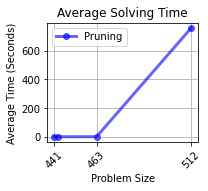

In [201]:
generate_graph(["rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop", "rover/pb4.jshop"],
               ["Pruning"], ["blue"],
               [
                   [
                       JSHOP_Solve_bf_pruning_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_bf_pruning_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_bf_pruning_av_time["rover/pb3.jshop"],
                       JSHOP_Solve_bf_pruning_av_time["rover/pb4.jshop"]
                   ]
               ], "Average Solving Time", fig_size=(2.7,2.2), xticks=[size_dict["rover/pb1.jshop"], size_dict["rover/pb3.jshop"], size_dict["rover/pb4.jshop"]], save_name="JSHOP_Rover_BFP.pdf")

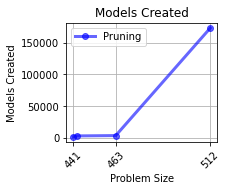

In [182]:
generate_graph(["rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop", "rover/pb4.jshop"],
               ["Pruning"], ["blue"],
               [
                   [
                       JSHOP_Solve_bf_pruning_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_bf_pruning_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_bf_pruning_av_time.get_num_models("rover/pb3.jshop"),
                       JSHOP_Solve_bf_pruning_av_time.get_num_models("rover/pb4.jshop")
                   ]
               ], "Models Created", "Models Created", fig_size=(2.7,2.2), xticks=[size_dict["rover/pb1.jshop"], size_dict["rover/pb3.jshop"], size_dict["rover/pb4.jshop"]], save_name="JSHOP_Rover_BF_Models.pdf")

## Graph JSHOP Rover Tree Distance

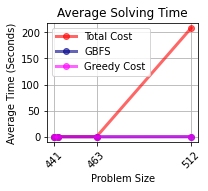

In [183]:
generate_graph(["rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop", "rover/pb4.jshop"],
               ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                       JSHOP_Solve_tree_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_tree_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_tree_av_time["rover/pb3.jshop"],
                       JSHOP_Solve_tree_av_time["rover/pb4.jshop"]
                   ],
                   [
                       JSHOP_Solve_tree_GBFS_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_tree_GBFS_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_tree_GBFS_av_time["rover/pb3.jshop"],
                       JSHOP_Solve_tree_GBFS_av_time["rover/pb4.jshop"]
                   ],
                   [
                       JSHOP_Solve_tree_GCost_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_tree_GCost_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_tree_GCost_av_time["rover/pb3.jshop"],
                       JSHOP_Solve_tree_GCost_av_time["rover/pb4.jshop"]
                   ]
               ], "Average Solving Time", fig_size=(2.7,2.2), xticks=[size_dict["rover/pb1.jshop"], size_dict["rover/pb3.jshop"], size_dict["rover/pb4.jshop"]], save_name="JSHOP_Rover_TR.pdf")

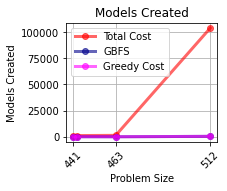

In [184]:
generate_graph(["rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop", "rover/pb4.jshop"],
               ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                       JSHOP_Solve_tree_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_tree_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_tree_av_time.get_num_models("rover/pb3.jshop"),
                       JSHOP_Solve_tree_av_time.get_num_models("rover/pb4.jshop")
                   ],
                   [
                       JSHOP_Solve_tree_GBFS_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_tree_GBFS_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_tree_GBFS_av_time.get_num_models("rover/pb3.jshop"),
                       JSHOP_Solve_tree_GBFS_av_time.get_num_models("rover/pb4.jshop")
                   ],
                   [
                       JSHOP_Solve_tree_GCost_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_tree_GCost_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_tree_GCost_av_time.get_num_models("rover/pb3.jshop"),
                       JSHOP_Solve_tree_GCost_av_time.get_num_models("rover/pb4.jshop")
                   ]
               ], "Models Created", "Models Created", fig_size=(2.7,2.2), xticks=[size_dict["rover/pb1.jshop"], size_dict["rover/pb3.jshop"], size_dict["rover/pb4.jshop"]], save_name="JSHOP_Rover_TR_Models.pdf")

## Graph JSHOP Rover Hamming Distance

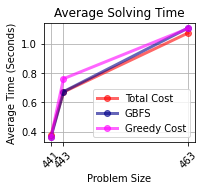

In [185]:
generate_graph(["rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop"],
               ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                       JSHOP_Solve_hamming_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_hamming_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_hamming_av_time["rover/pb3.jshop"]
                   ],
                   [
                       JSHOP_Solve_hamming_GBFS_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_hamming_GBFS_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_hamming_GBFS_av_time["rover/pb3.jshop"]
                   ],
                   [
                       JSHOP_Solve_hamming_GCost_av_time["rover/pb1.jshop"],
                       JSHOP_Solve_hamming_GCost_av_time["rover/pb2.jshop"],
                       JSHOP_Solve_hamming_GCost_av_time["rover/pb3.jshop"]
                   ]
               ], "Average Solving Time", fig_size=(2.7,2.2), save_name="JSHOP_Rover_HM.pdf")

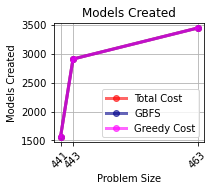

In [186]:
generate_graph(["rover/pb1.jshop", "rover/pb2.jshop", "rover/pb3.jshop"],
               ["Total Cost", "GBFS", "Greedy Cost"], ["red", "darkblue", "magenta"],
               [
                   [
                       JSHOP_Solve_hamming_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_hamming_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_hamming_av_time.get_num_models("rover/pb3.jshop")
                   ],
                   [
                       JSHOP_Solve_hamming_GBFS_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_hamming_GBFS_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_hamming_GBFS_av_time.get_num_models("rover/pb3.jshop")
                   ],
                   [
                       JSHOP_Solve_hamming_GCost_av_time.get_num_models("rover/pb1.jshop"),
                       JSHOP_Solve_hamming_GCost_av_time.get_num_models("rover/pb2.jshop"),
                       JSHOP_Solve_hamming_GCost_av_time.get_num_models("rover/pb3.jshop")
                   ]
               ], "Models Created", "Models Created", fig_size=(2.7,2.2), save_name="JSHOP_Rover_HM_Models.pdf")

## Spearmans Test

In [187]:
from scipy.stats import spearmanr
def populate_lists_spearman(times, models, problems_to_add, strats_to_add):
    for p_name in problems_to_add:
        for s in strats_to_add:
            if p_name in s.times:
                times.append(s[p_name])
                models.append(s.get_num_models(p_name))
    return times, models

time_list = []
models_list = []

problem_list = [x for x in breadth_first.example_name.unique()]
strat_list = [breadth_first_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in breadth_first_pruning.example_name.unique()]
strat_list = [breadth_first_pruning_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in hamming_distance.example_name.unique()]
strat_list = [hamming_distance_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in hamming_distance_GBFS.example_name.unique()]
strat_list = [hamming_distance_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in hamming_distance_GCost.example_name.unique()]
strat_list = [hamming_distance_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in tree_distance.example_name.unique()]
strat_list = [tree_distance_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in tree_distance_GBFS.example_name.unique()]
strat_list = [tree_distance_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in tree_distance_GCost.example_name.unique()]
strat_list = [tree_distance_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in delete_relaxed.example_name.unique()]
strat_list = [delete_relaxed_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in delete_relaxed_GBFS.example_name.unique()]
strat_list = [delete_relaxed_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in delete_relaxed_GCost.example_name.unique()]
strat_list = [delete_relaxed_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_breadth_first.example_name.unique()]
strat_list = [PO_breadth_first_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_breadth_first_pruning.example_name.unique()]
strat_list = [PO_breadth_first_pruning_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_delete_relaxed.example_name.unique()]
strat_list = [PO_delete_relaxed_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_delete_relaxed_GBFS.example_name.unique()]
strat_list = [PO_delete_relaxed_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_delete_relaxed_GCost.example_name.unique()]
strat_list = [PO_delete_relaxed_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_tree_distance.example_name.unique()]
strat_list = [PO_tree_distance_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_tree_distance_GBFS.example_name.unique()]
strat_list = [PO_tree_distance_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_tree_distance_GCost.example_name.unique()]
strat_list = [PO_tree_distance_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_hamming_distance.example_name.unique()]
strat_list = [PO_hamming_distance_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_hamming_distance_GBFS.example_name.unique()]
strat_list = [PO_hamming_distance_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in PO_hamming_distance_GCost.example_name.unique()]
strat_list = [PO_hamming_distance_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in JSHOP_Solve_bf.example_name.unique()]
strat_list = [JSHOP_Solve_bf_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in JSHOP_Solve_bf_pruning.example_name.unique()]
strat_list = [JSHOP_Solve_bf_pruning_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in JSHOP_Solve_tree.example_name.unique()]
strat_list = [JSHOP_Solve_tree_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in JSHOP_Solve_tree_GBFS.example_name.unique()]
strat_list = [JSHOP_Solve_tree_GBFS_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

problem_list = [x for x in JSHOP_Solve_tree_GCost.example_name.unique()]
strat_list = [JSHOP_Solve_tree_GCost_av_time]
time_list, models_list = populate_lists_spearman(time_list, models_list, problem_list, strat_list)

r = spearmanr(time_list, models_list)
r[0]

0.7950786101940518